In [1]:
# pip install tslearn

# Where should a drinks company run promotions?

## 📖 Background
Your company owns a chain of stores across Russia that sell a variety of alcoholic drinks. The company recently ran a wine promotion in Saint Petersburg that was very successful. Due to the cost to the business, it isn’t possible to run the promotion in all regions. The marketing team would like to target 10 other regions that have similar buying habits to Saint Petersburg where they would expect the promotion to be similarly successful.

### The data
The marketing team has sourced you with historical sales volumes per capita for several different drinks types.

- "year" - year (1998-2016)
- "region" - name of a federal subject of Russia. It could be oblast, republic, krai, autonomous okrug, federal city and a single autonomous oblast
- "wine" - sale of wine in litres by year per capita
- "beer" - sale of beer in litres by year per capita
- "vodka" - sale of vodka in litres by year per capita
- "champagne" - sale of champagne in litres by year per capita
- "brandy" - sale of brandy in litres by year per capita

In [46]:
# import basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from IPython.display import clear_output
import matplotlib.patches as patches
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

In [88]:
# load data
df = pd.read_csv(r'./data/russian_alcohol_consumption.csv')
df.head()

year              region  wine  beer  vodka  champagne  brandy
0  1998  Republic of Adygea   1.9   8.8    3.4        0.3     0.1
1  1998          Altai Krai   3.3  19.2   11.3        1.1     0.1
2  1998         Amur Oblast   2.1  21.2   17.3        0.7     0.4
3  1998  Arkhangelsk Oblast   4.3  10.6   11.7        0.4     0.3
4  1998    Astrakhan Oblast   2.9  18.0    9.5        0.8     0.2

## 💪 Competition challenge

1. Recommend 10 additional regions they should select for the promotion.
2. Tell the story that supports your recommendations.

## ❔ Questions
 1. Are there any changes of sales by time and drinks? How about Saint Petersburg?
 2. Where are 10 regions having similar preference of wine like Saint Peterburg? 

# The Dataset
##  **Understanding data**

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1615 entries, 0 to 1614
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   year       1615 non-null   int64  
 1   region     1615 non-null   object 
 2   wine       1552 non-null   float64
 3   beer       1557 non-null   float64
 4   vodka      1554 non-null   float64
 5   champagne  1552 non-null   float64
 6   brandy     1549 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 88.4+ KB


## Missing values

In [90]:
round(df.isnull().sum()/df.shape[0]*100,2)

year         0.00
region       0.00
wine         3.90
beer         3.59
vodka        3.78
champagne    3.90
brandy       4.09
dtype: float64

In [91]:
df.dropna(axis=0, inplace=True)
df.shape

(1549, 7)

#### Handiling missing values
Data have some missing values. Since the percentages of missing values are less than 5% of data set, it will not have impact to data analysis to drop missing data. Hence, missing values are removed. 

# **Exploratory Data Analysis**

## Changes of sales by time and drinks in Saint Petersburg

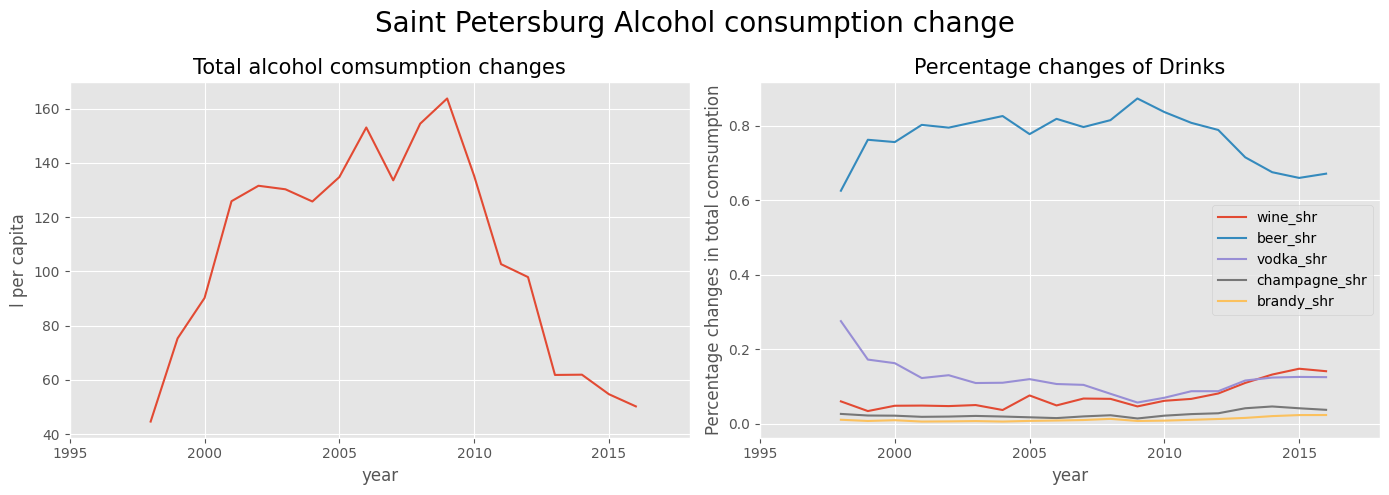

In [151]:
drinks = ['wine', 'beer', 'vodka', 'champagne', 'brandy']
year_region_group = df.groupby(['region', 'year'])[drinks].sum().reset_index()
saint_change = year_region_group[year_region_group['region']=='Saint Petersburg']
saint_change['total']= saint_change[drinks].sum(axis=1)
for d in drinks:
    saint_change[d + '_shr'] = saint_change.apply(lambda x: x[d] / x.total, axis=1)
saint_change.drop('region',axis=1, inplace=True)
saint_change.set_index('year', inplace=True)
saint_change
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 5), tight_layout=True)
sns.lineplot(data=saint_change['total'], dashes=False,ax=ax1)
ax1.set_title('Total alcohol comsumption changes', fontsize=15)
ax1.set(
        xlabel = 'year', 
        ylabel = 'l per capita',
        xlim = (1995, 2018)
    )
sns.lineplot(data=saint_change.iloc[:,6:], dashes=False,ax=ax2)
ax2.set_title('Percentage changes of Drinks', fontsize=15)
ax2.set(
         xlabel = 'year', 
         ylabel = 'Percentage changes in total comsumption',
         xlim = (1995, 2018)
     )
plt.suptitle('Saint Petersburg Alcohol consumption change', fontsize=20)
plt.show()

* Total consumption had sharply increased until 2009. After reaching peak, it dropped close to its previous level of consumption.
* The largest percentage of sales is beer. It kept increased until 2008 then fluctuated and reached a peak at 2010. It has decreased after reaching the highest level. Sales of other drinks are not fluctuating compared to beer. However, we need to closely look at each changes of sales level due to consumption levels are quite different by drinks. 

## National wide and Saint Petersburg Alcohol consumption changes

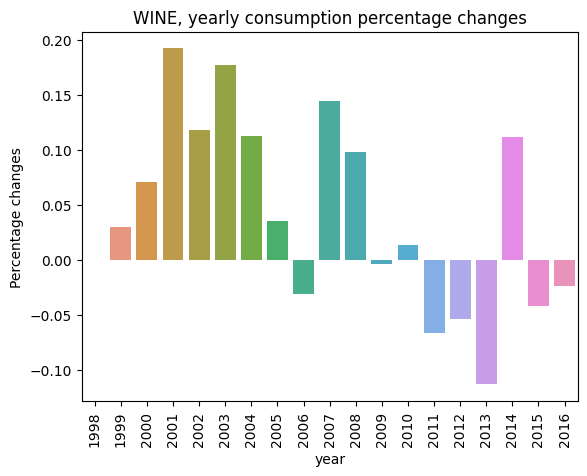

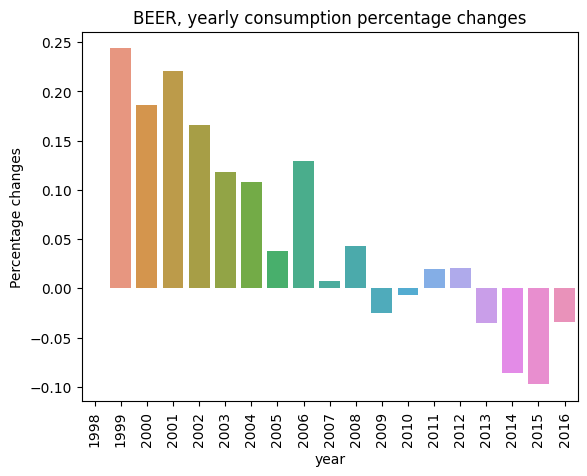

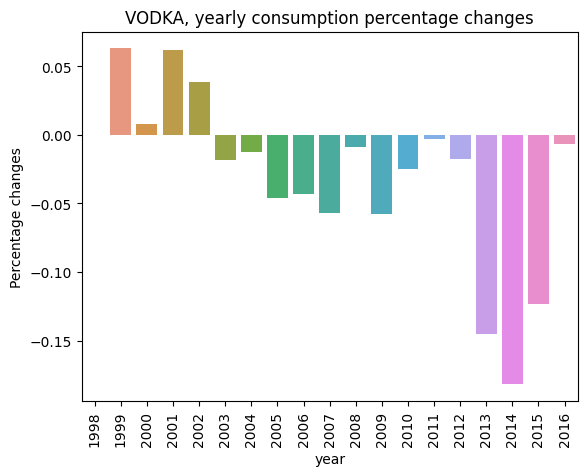

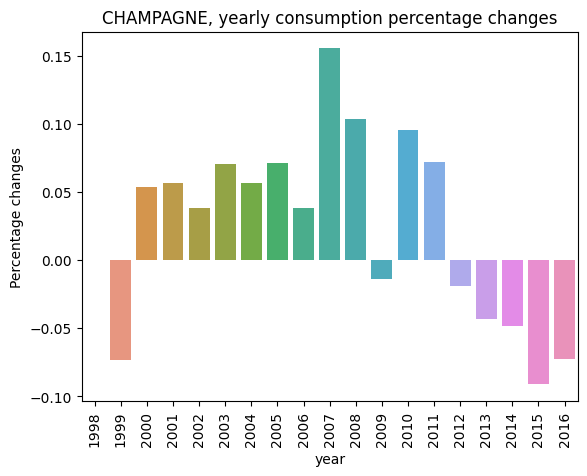

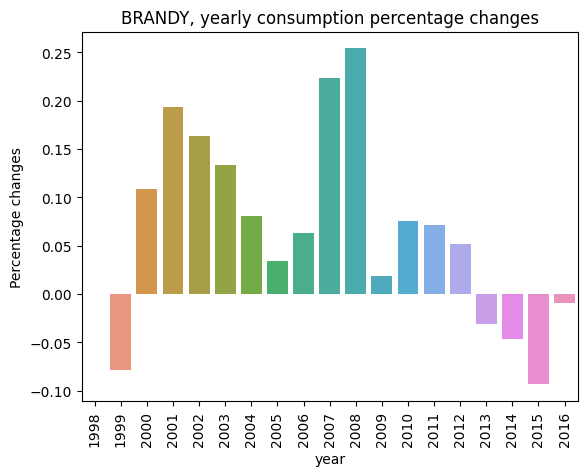

In [9]:
df.groupby('year')[drinks].
# year_change=yearly_consumption.pct_change()
# for col in drinks:
#     sns.barplot(data=year_change,x=year_change.index.year,y=col)
#     plt.xticks(rotation=90)
#     plt.ylabel('Percentage changes')
#     plt.title(str(col).upper()+','+' yearly consumption percentage changes')
#     plt.show()

*Wine* sales had positive percentage changes before 2006. Its direction changed following 2 years then it had negative or small positive changes until 2014. 

When it comes to *beer* sales, its levels of percentage had postive numbers until 2009 but degree of percentage changes were reduced as time passed then its level became negative.  

*Vodka* also had negtive direction of percentage changes all times. It had positive numbers before 2002 then its sales reduced then previous years. 

*Champagne* sales had increased between 2000 and 2008 then it fluctuated for 3 years and changed to negative percentage sales.

*Brandy* sales percentage changes are simlilar to champagne but it had positive levels of changes from 2000 to 2012, and it went to opposite direction.



#### Regions ranked top 10 sales of drinks for 18 years

In [10]:
def top10_region(col='wine'):
    temp=df.loc[:,['year','region',col]].groupby('year').apply(lambda x:x.nlargest(10,col))
    temp=temp.droplevel(level=1).drop('year',axis=1)
    return temp.region.value_counts()[:10]

In [11]:
for col in drinks:
    clear_output(wait=True) #clear the output of previous display
    print('Regions frequetly ranked in top10 from 1998 to 2016 '+str(col).upper() +' demand')
    display(pd.DataFrame({'Region':top10_region(col=col).index,
                        'Number of times ranked Top 10 ':top10_region(col=col).values}).set_index('Region'))
    time.sleep(2)
    

Regions frequetly ranked in top10 from 1998 to 2016 WINE demand


Number of times ranked Top 10 
Region                                                 
Komi Republic                                        16
Pskov Oblast                                         15
Republic of Karelia                                  15
Nenets Autonomous Okrug                              13
Novgorod Oblast                                      11
Vologda Oblast                                       11
Arkhangelsk Oblast                                   11
Kirov Oblast                                          7
Krasnodar Krai                                        7
Kaliningrad Oblast                                    6

Regions frequetly ranked in top10 from 1998 to 2016 BEER demand


Number of times ranked Top 10 
Region                                                               
Moscow                                                             16
Omsk Oblast                                                        12
Sverdlovsk Oblast                                                  12
Saint Petersburg                                                   12
Yamalo-Nenets Autonomous Okrug                                     12
Tyumen Oblast                                                      11
Khanty–Mansi Autonomous Okrug – Yugra                               9
Khabarovsk Krai                                                     9
Ivanovo Oblast                                                      9
Moscow Oblast                                                       8

Regions frequetly ranked in top10 from 1998 to 2016 VODKA demand


Number of times ranked Top 10 
Region                                                 
Kamchatka Krai                                       18
Moscow                                               17
Komi Republic                                        16
Sakhalin Oblast                                      13
Magadan Oblast                                       13
Nenets Autonomous Okrug                              12
Arkhangelsk Oblast                                   11
Vologda Oblast                                       10
Khabarovsk Krai                                       9
Republic of Karelia                                   9

Regions frequetly ranked in top10 from 1998 to 2016 CHAMPAGNE demand


Number of times ranked Top 10 
Region                                                   
Moscow                                                 19
Murmansk Oblast                                        17
Magadan Oblast                                         16
Saint Petersburg                                       16
Kamchatka Krai                                         14
Sakhalin Oblast                                        12
Chukotka Autonomous Okrug                              11
Khabarovsk Krai                                        10
Moscow Oblast                                          10
Volgograd Oblast                                        8

Regions frequetly ranked in top10 from 1998 to 2016 BRANDY demand


Number of times ranked Top 10 
Region                                                   
Moscow                                                 18
Kamchatka Krai                                         17
Kaliningrad Oblast                                     15
Murmansk Oblast                                        14
Saint Petersburg                                       13
Moscow Oblast                                          12
Leningrad Oblast                                       12
Chukotka Autonomous Okrug                              10
Sakhalin Oblast                                         9
Magadan Oblast                                          8

The tables above show regions of frequently ranked on top 10 sales for 18 years. 
Komi Republic was the most often top 10 ranked region in wine demand. Moscow was the place frequently ranked top 10 on beer, champagne, and brandy sales  for 18 years and placed on 2nd on vodka.

#### Top 10 sales regions by year

In [12]:
def yearly_top10_plot(col='wine'):
    temp1=df.loc[:,['year','region',col]].groupby('year').apply(lambda x:x.nlargest(10,col))
    temp1=temp1.droplevel(level=1).drop('year',axis=1)
    for i in temp1.index.unique():
        clear_output(wait=True)
        ax=sns.barplot(data=temp1[temp1.index == i],x=col,y='region')
        ax.set_xticks(np.arange(0,int(temp1[col].max()+1),step=1))
        ax.set_xticklabels(ax.get_xticklabels([]))
#         ax.xaxis.set_tick_params(labelsize=8)
        ax.set_title(str(i.year) +', '+ 'Top 10 '+ col +' Demand (litres by year per capita)')
        for p in ax.patches:
            plt.text(p.get_width()+0.2, p.get_y()+0.5,
                 str(round((p.get_width()), 2)),
                 fontsize = 10, fontweight ='bold',
                 color ='grey')
        plt.show()
        time.sleep(2)

##### **Wine**

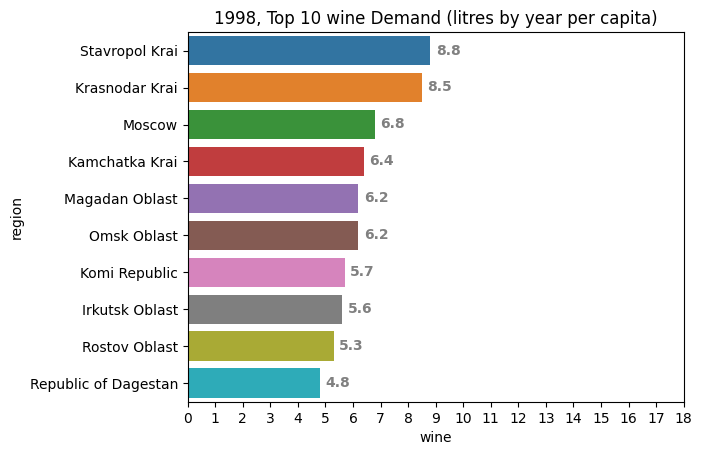

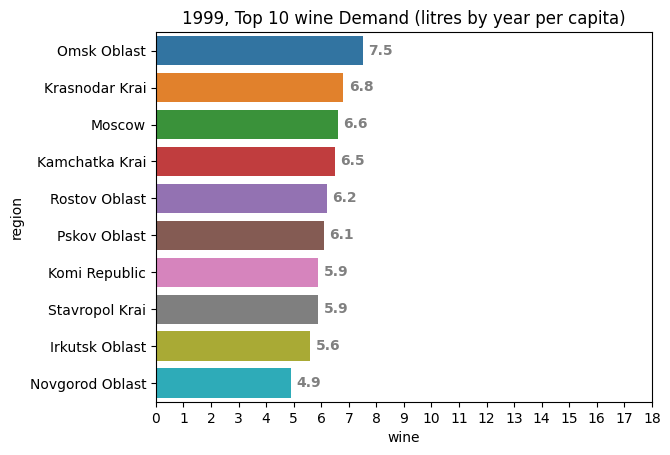

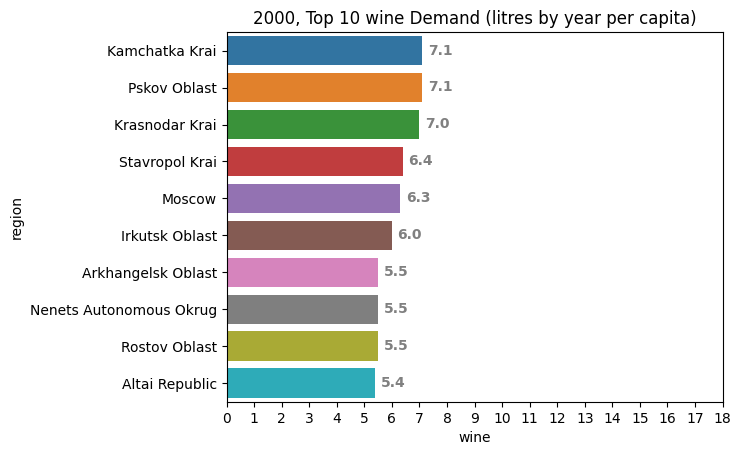

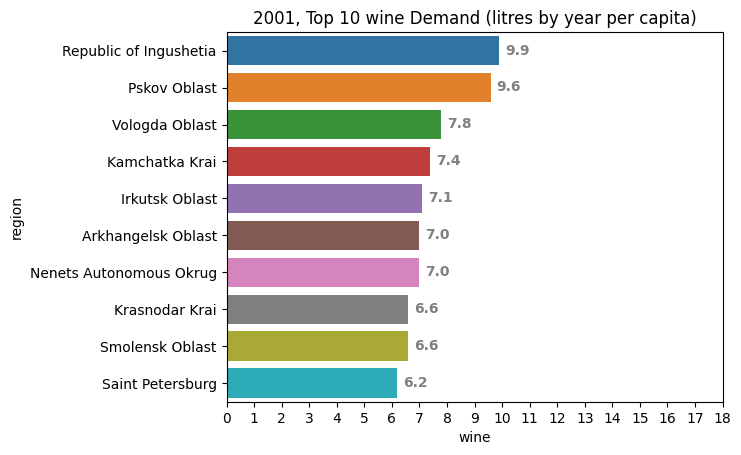

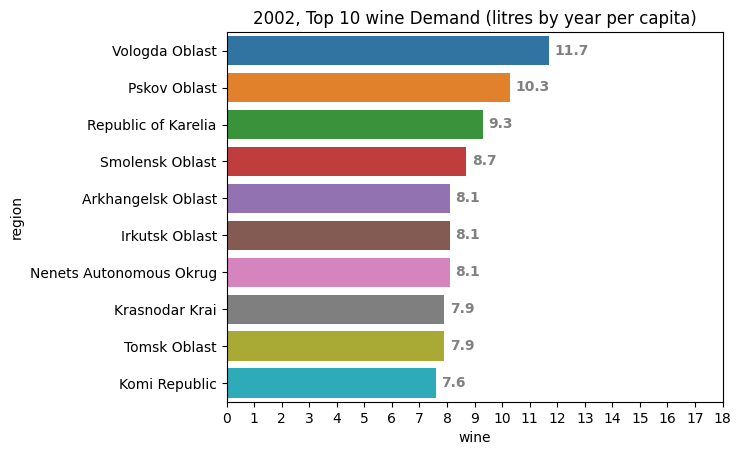

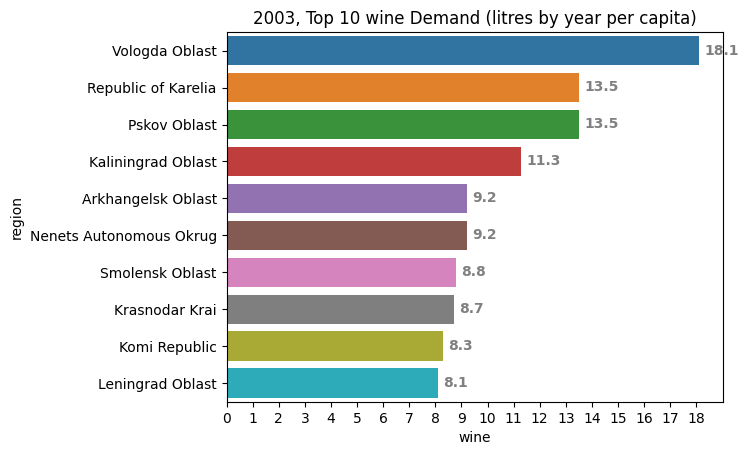

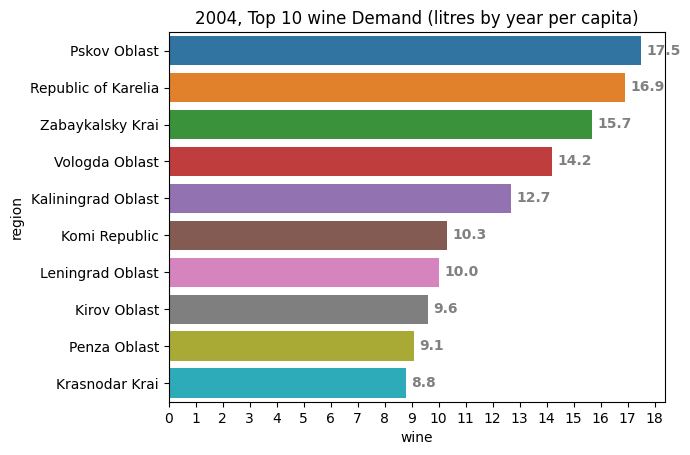

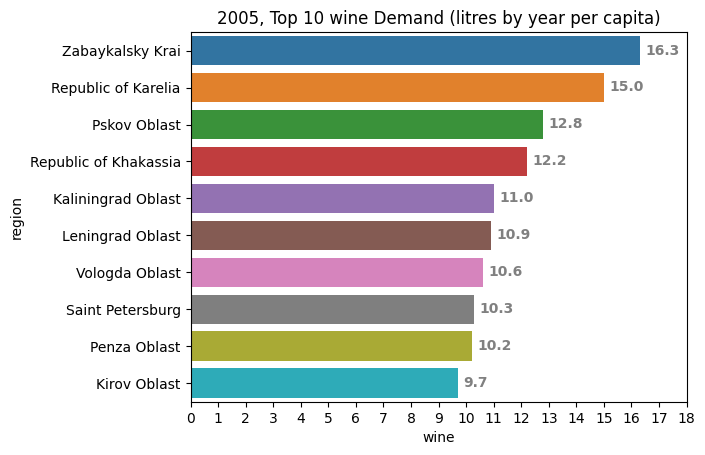

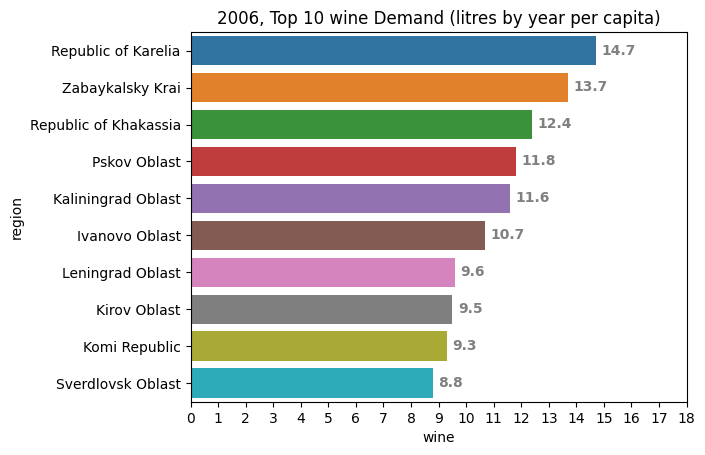

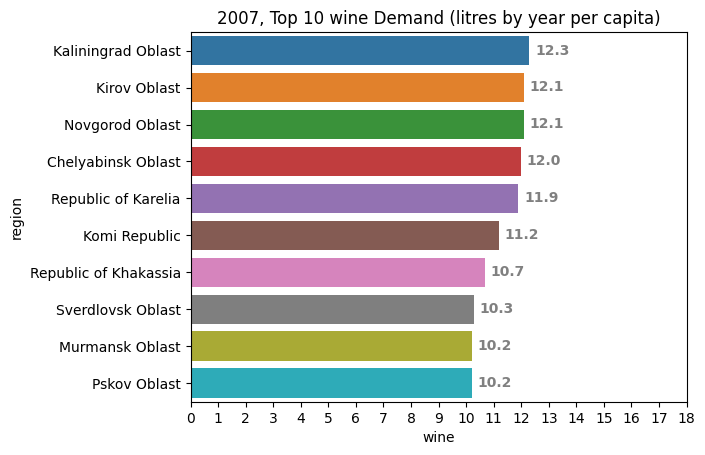

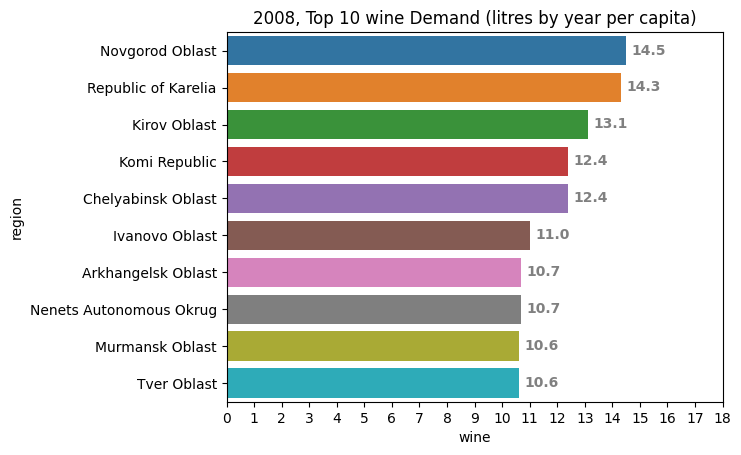

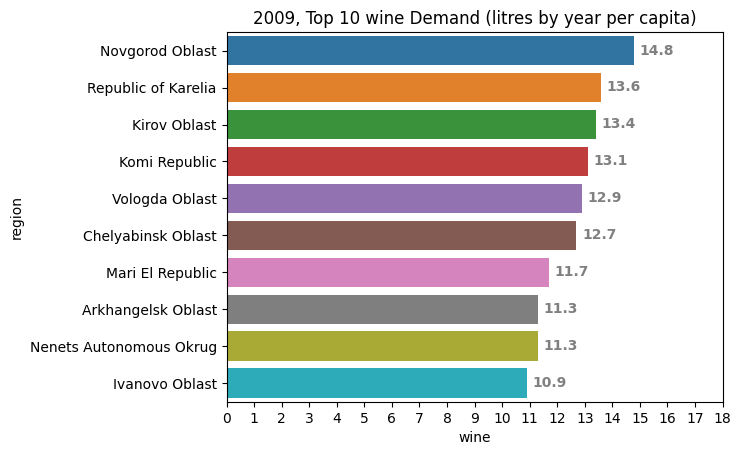

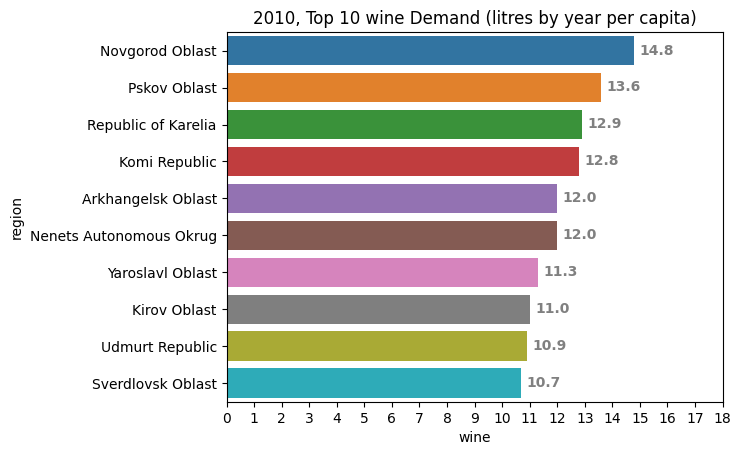

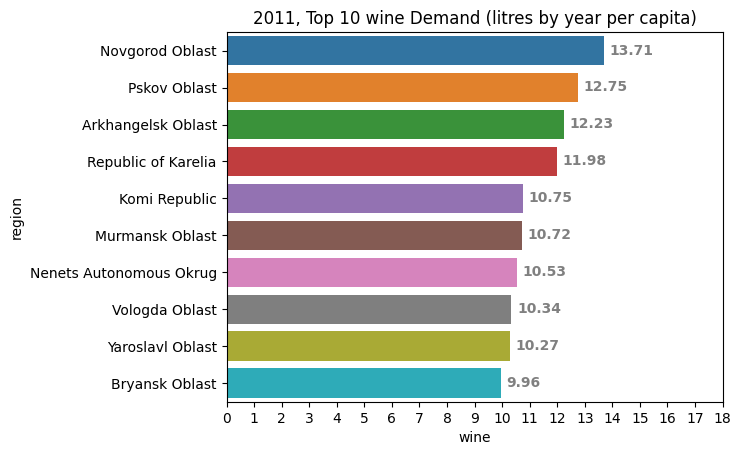

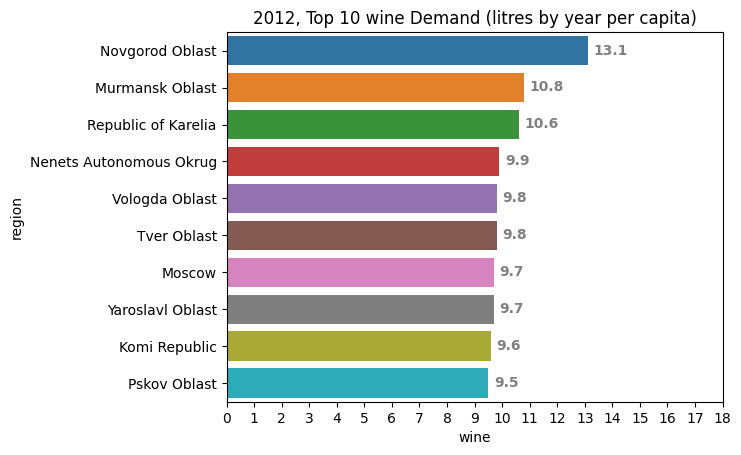

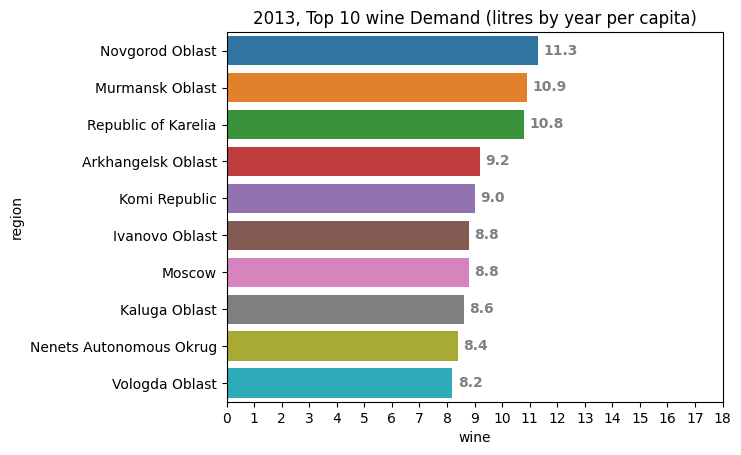

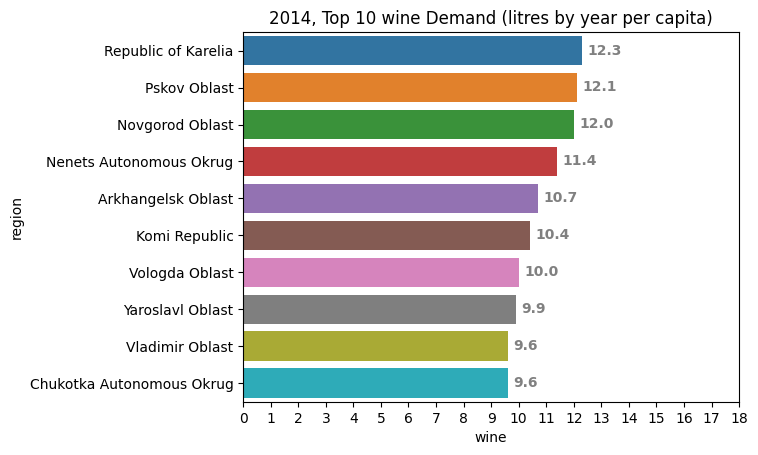

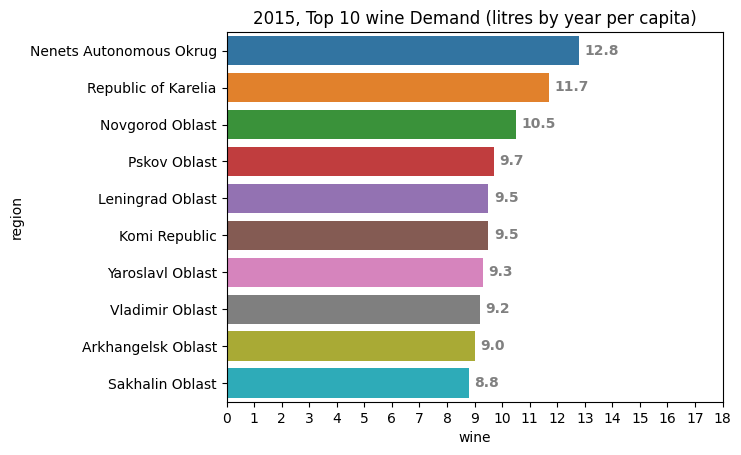

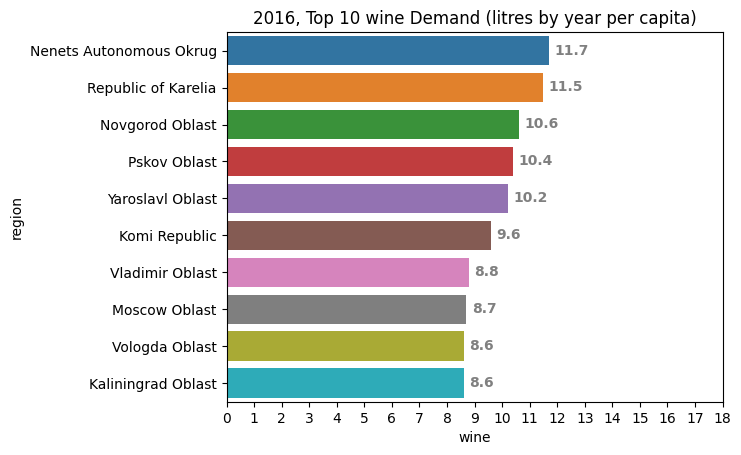

In [13]:
# Top 10 most wine demand regions by year 
yearly_top10_plot(col='wine')

The above tables show top10 most wine consumed regions and its amounts by year. Although there was no region ranked on top all the times,but Novgorod Oblast placed the top 3 times from 2011 to 2013 and Nenets Autonomous Okrug had 2 times on the highest in 2015 and 2016.

##### **Beer**

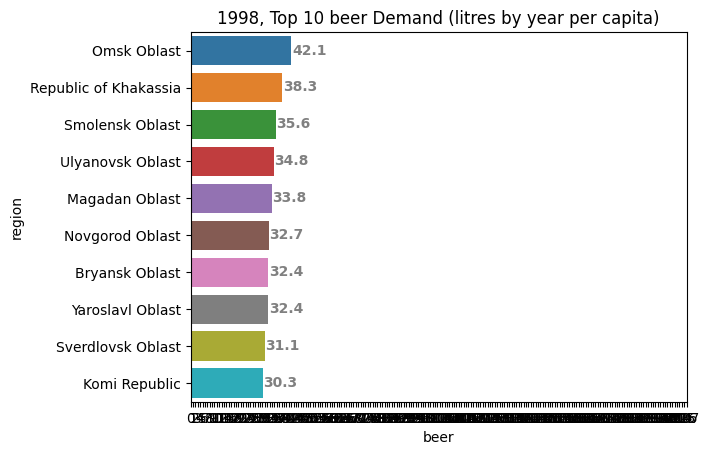

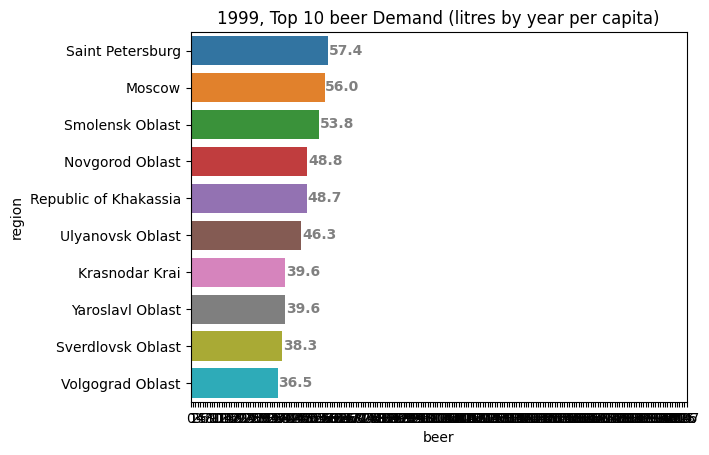

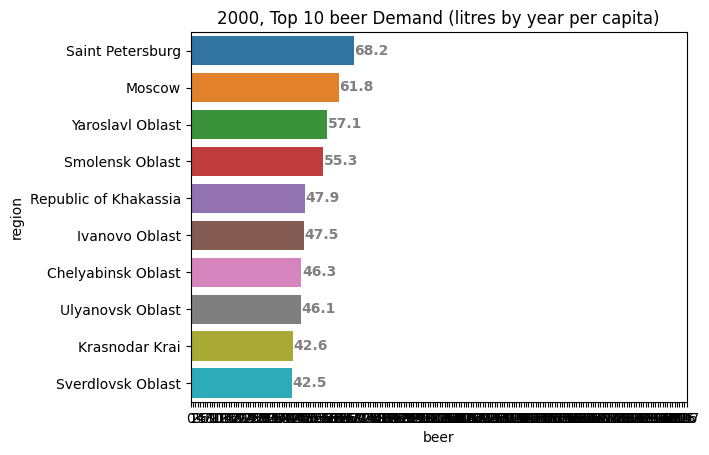

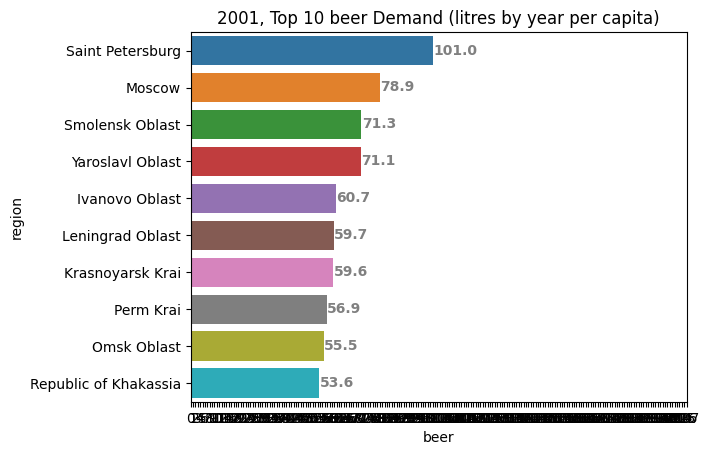

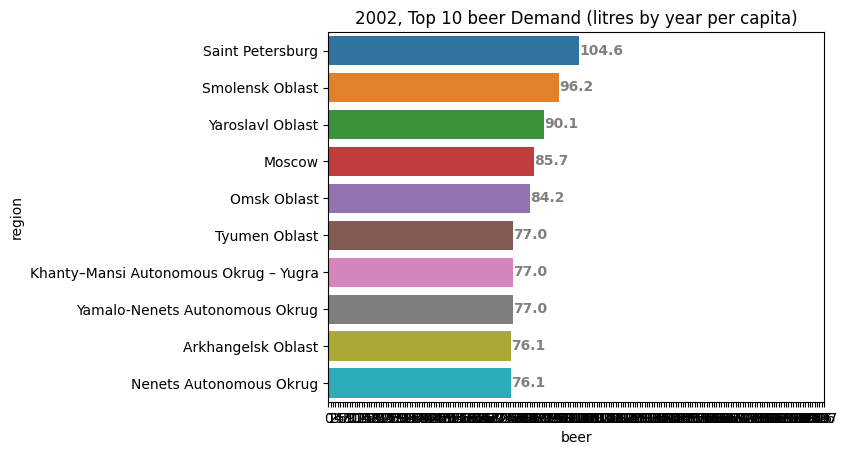

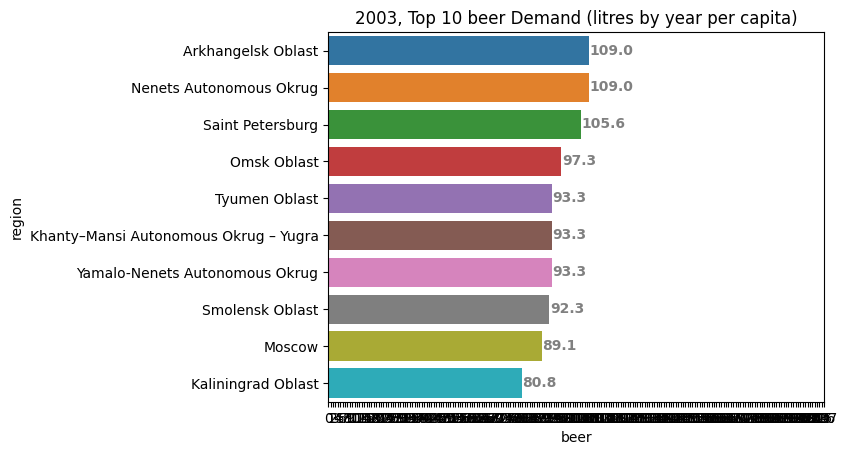

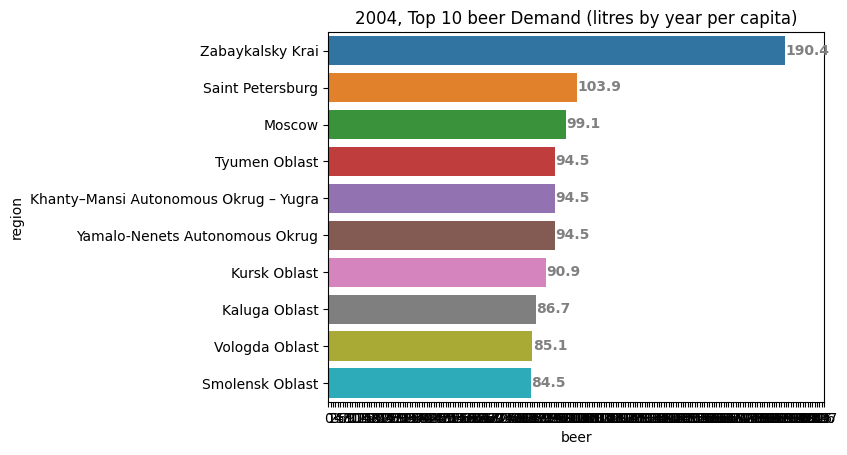

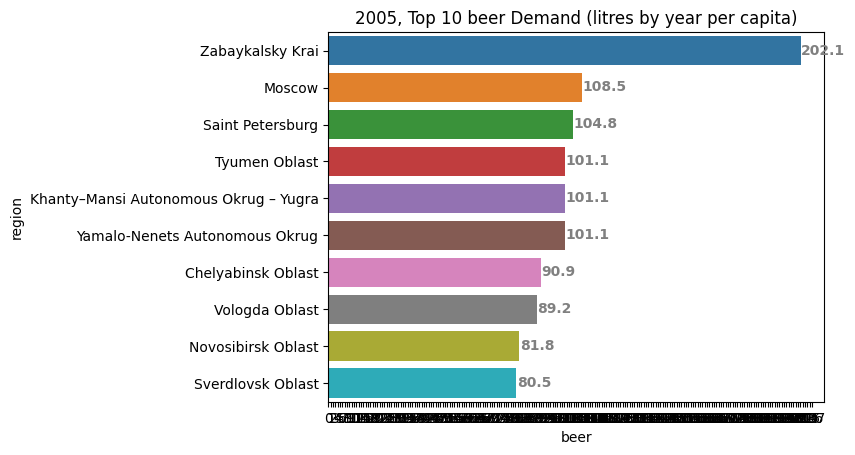

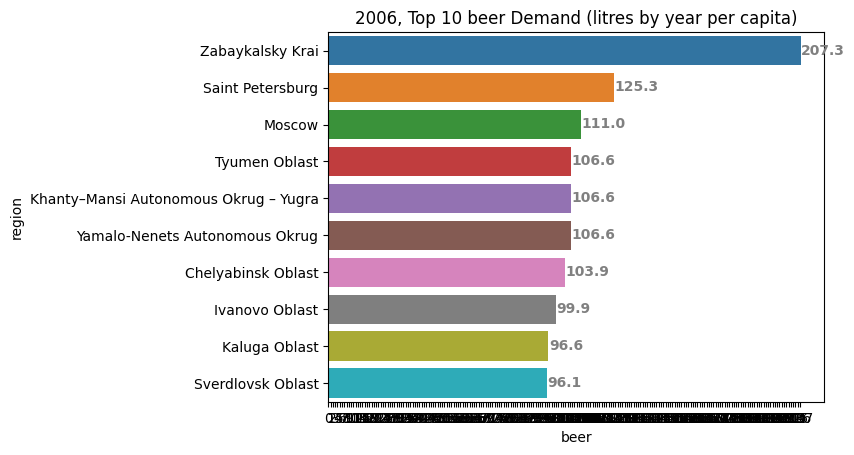

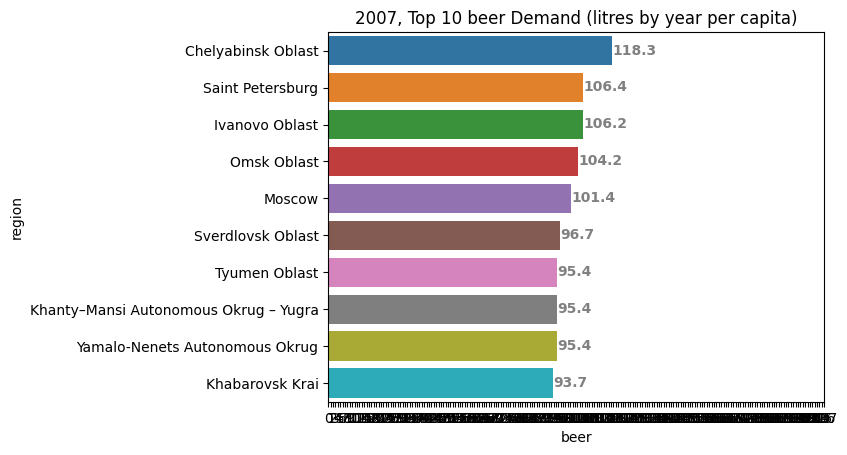

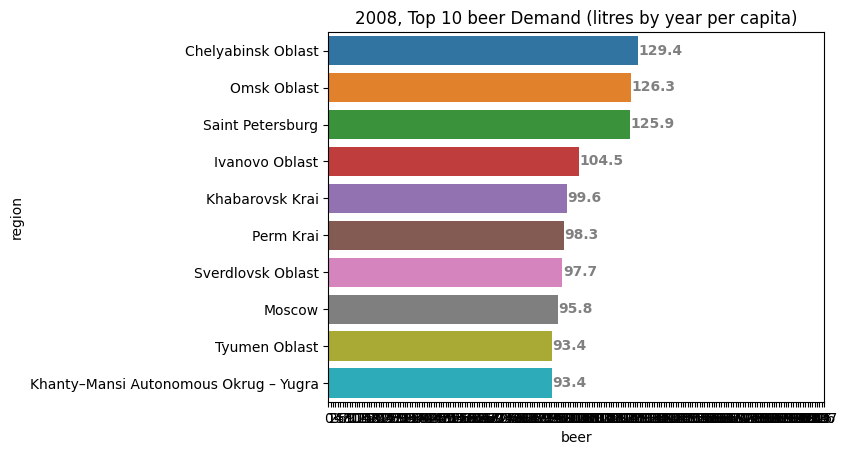

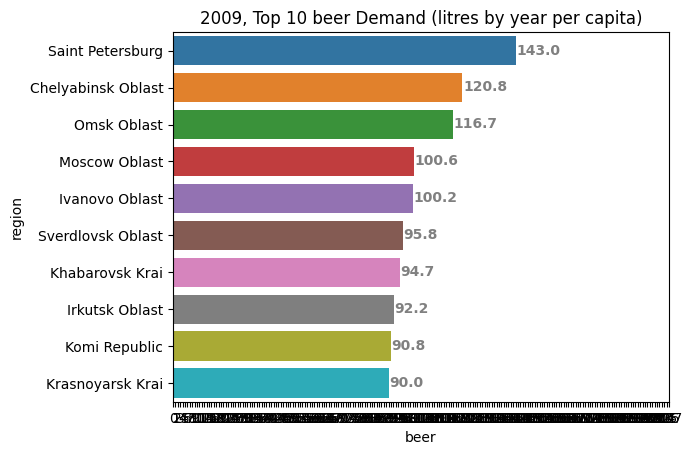

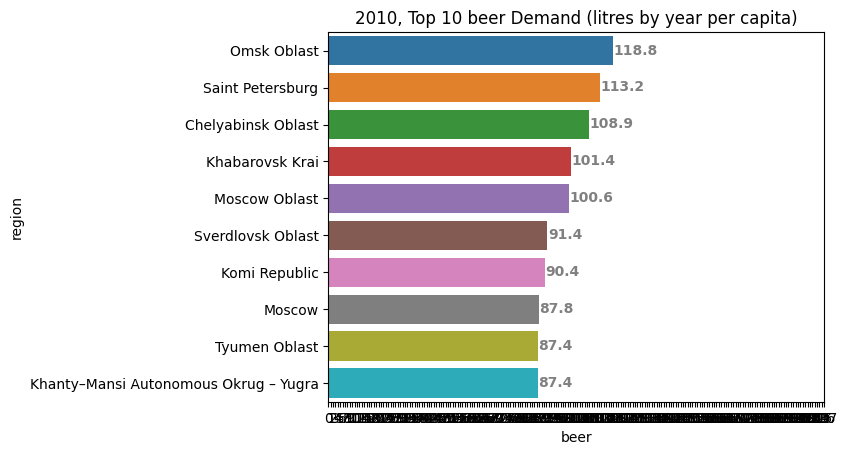

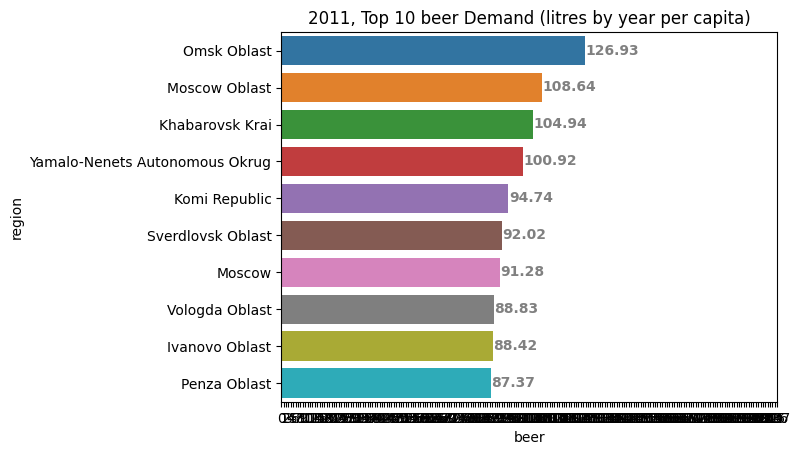

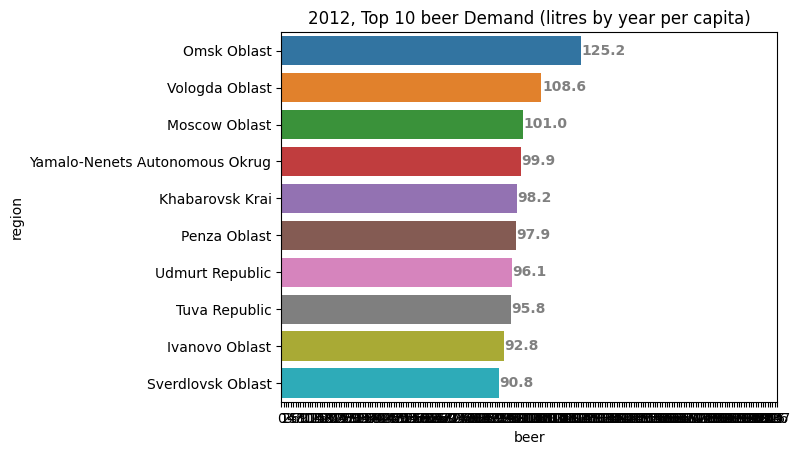

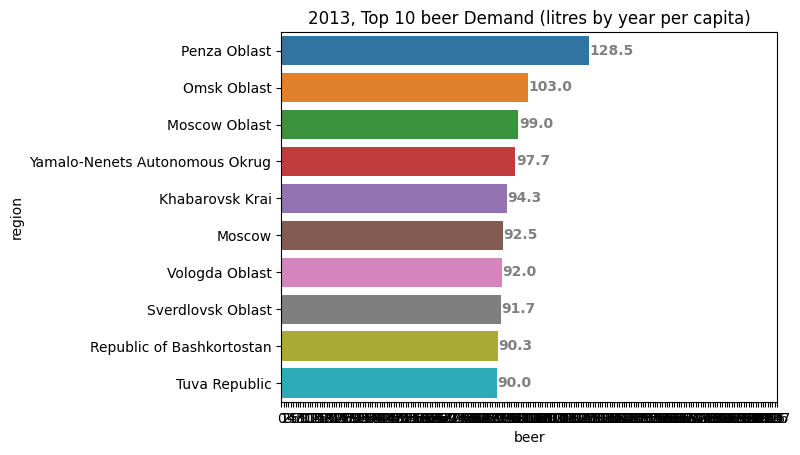

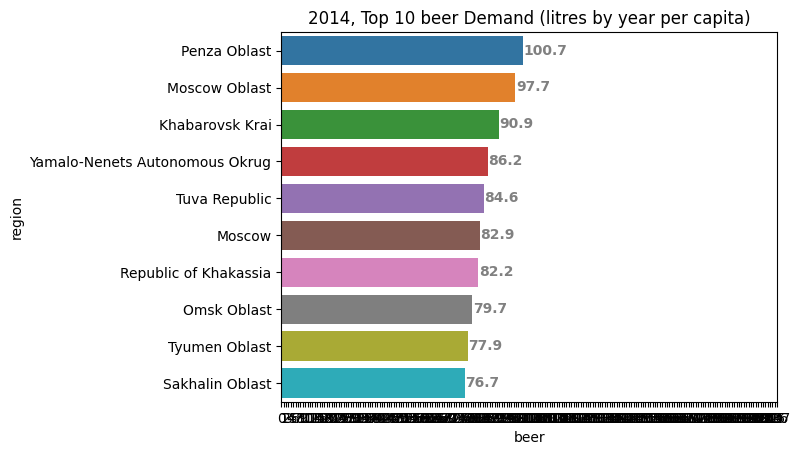

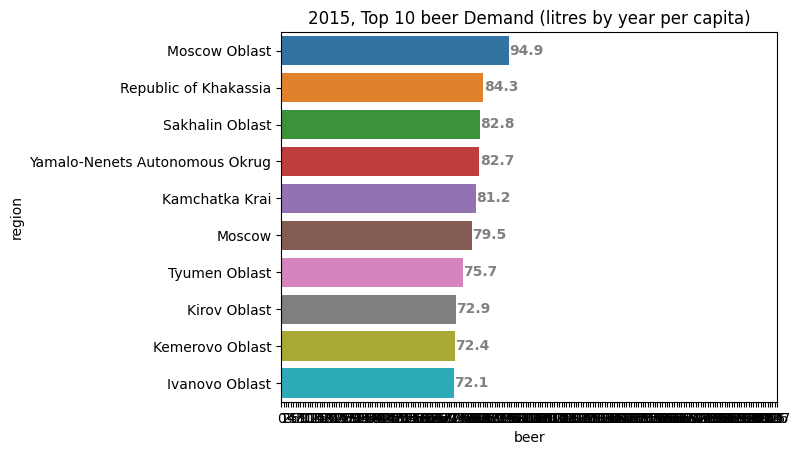

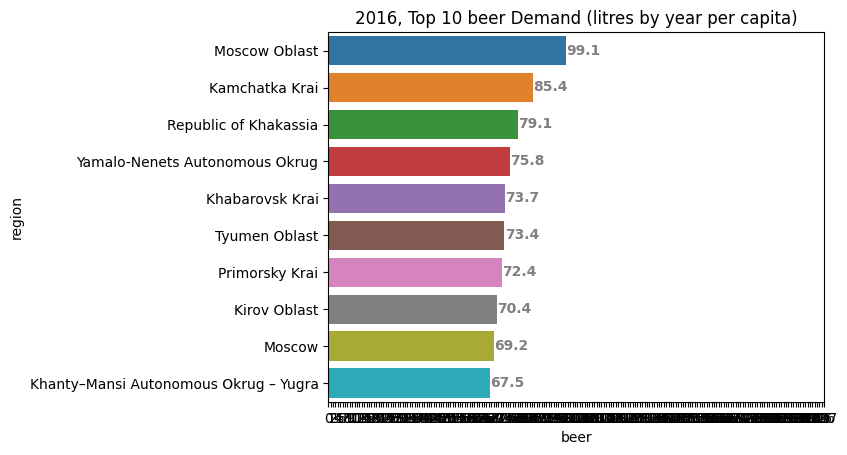

In [14]:
# Top 10 most beer demand regions by year 
yearly_top10_plot(col='beer') 

Saint Petersburg ranked on high position from 1999 to 2010 and Moscow also frequently ranked on high levels on beer consumption. After 2004 Zabaykaisky Krai showed Overwhelming consumption for 3 years then had not placed on top 10 rank following years.

##### **Vodka**

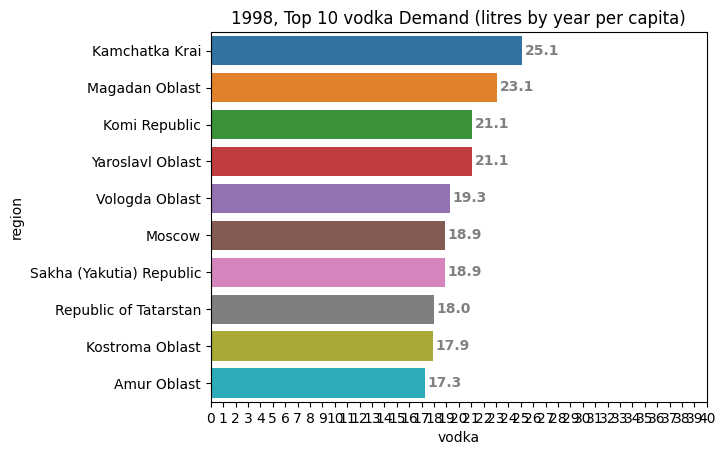

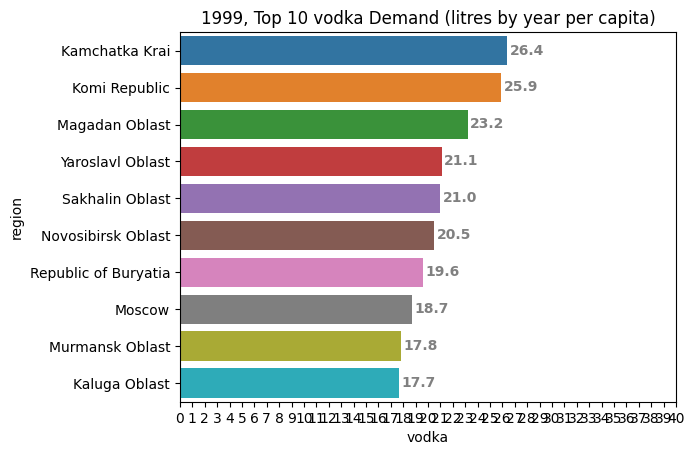

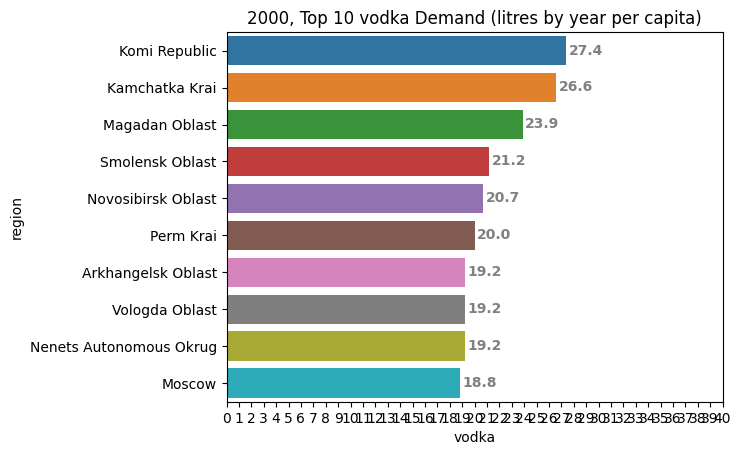

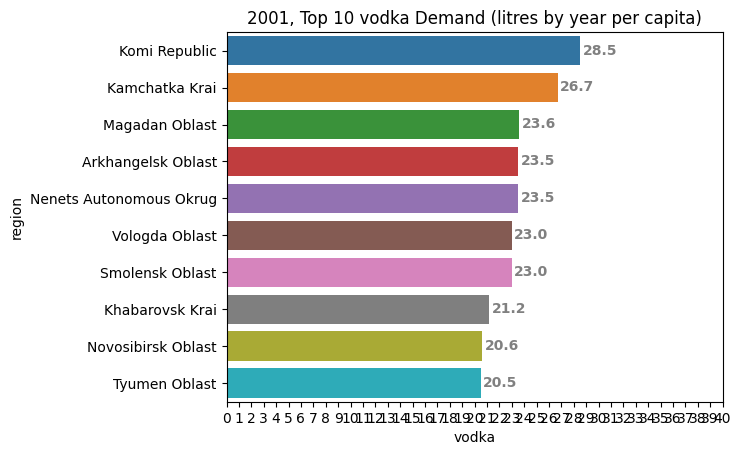

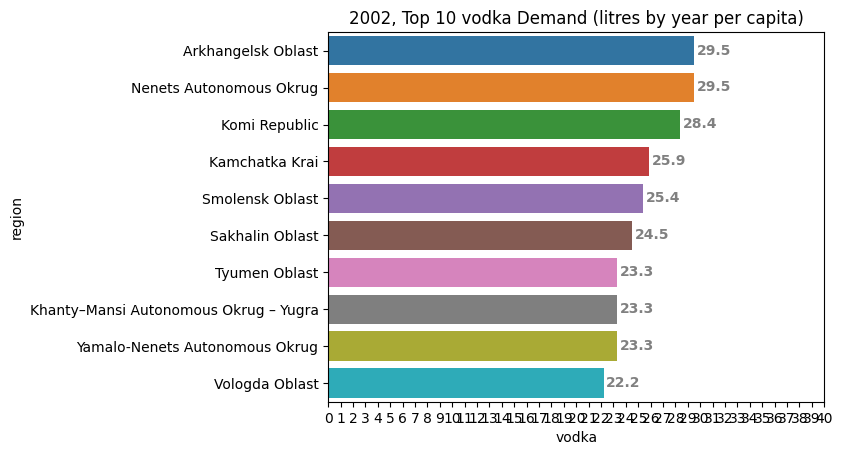

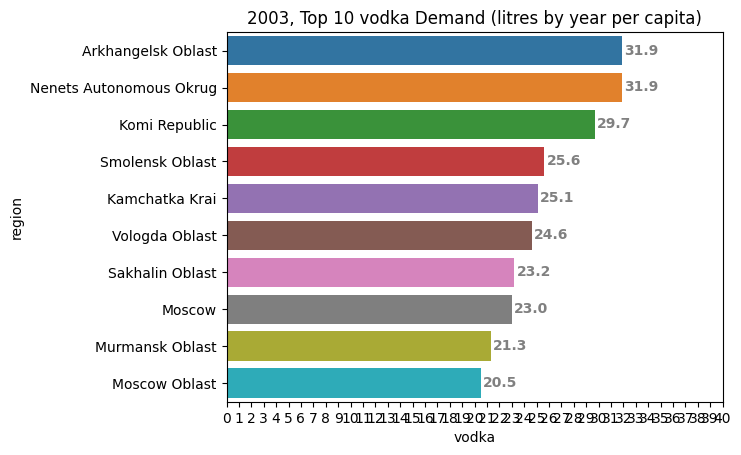

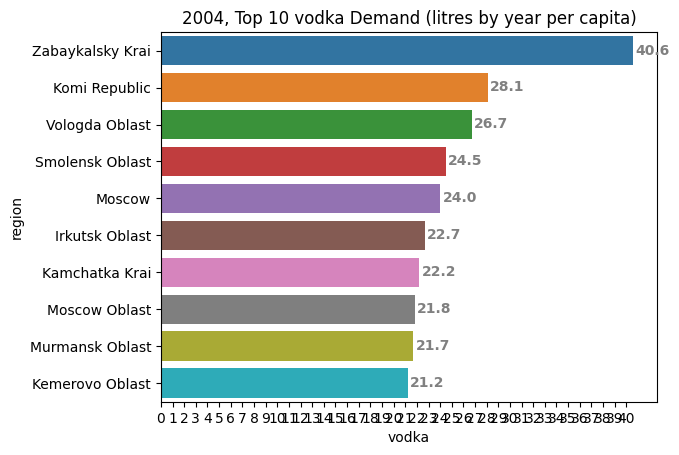

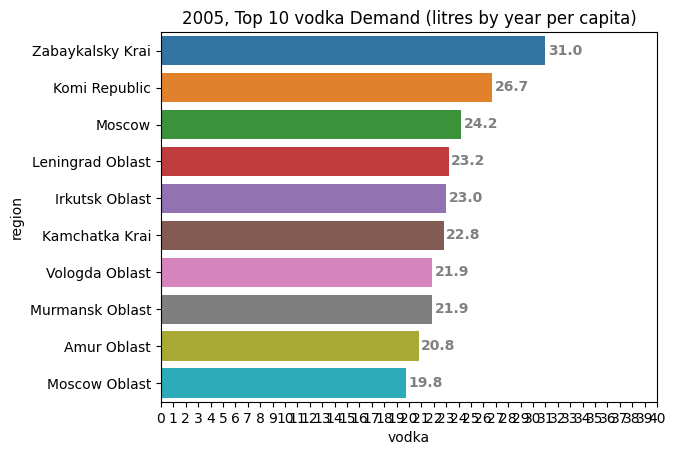

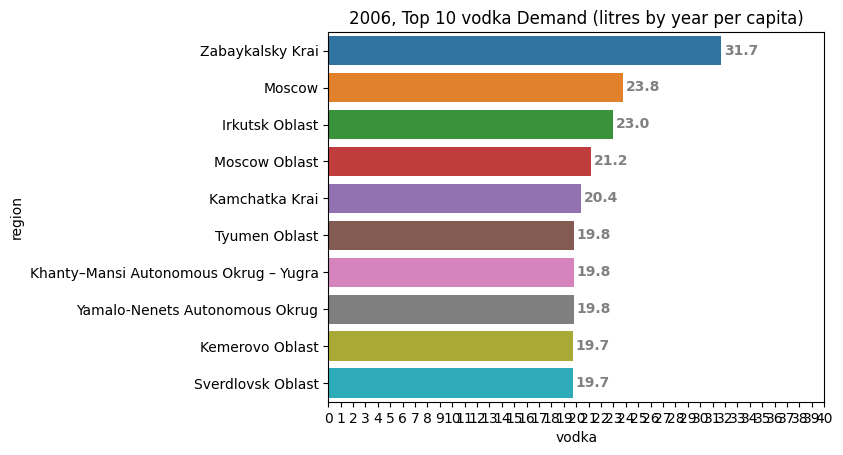

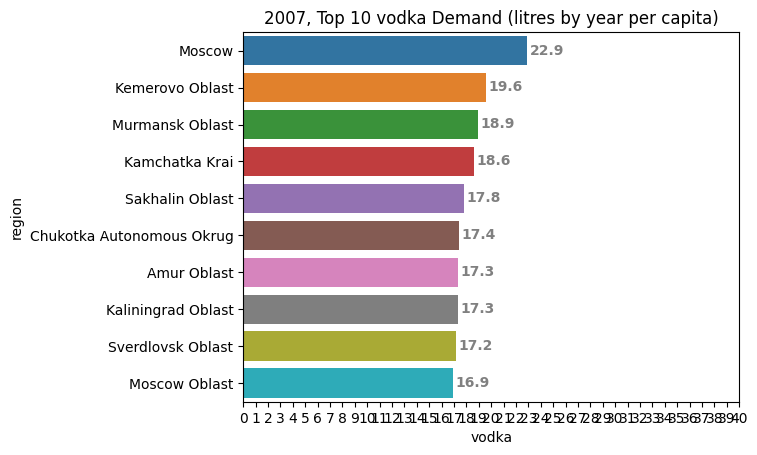

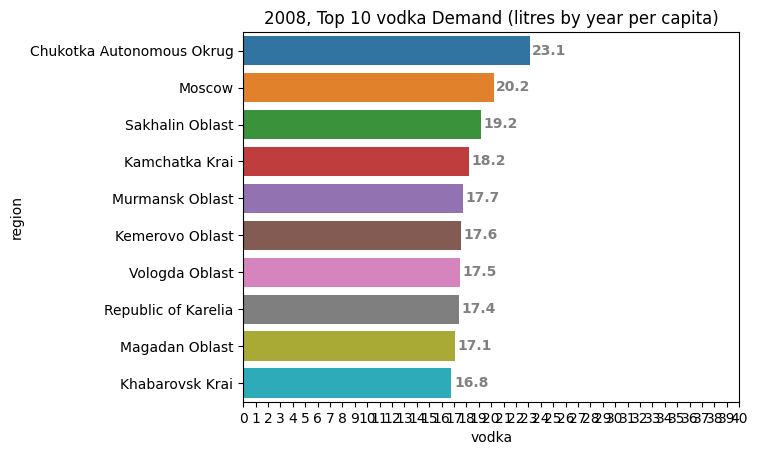

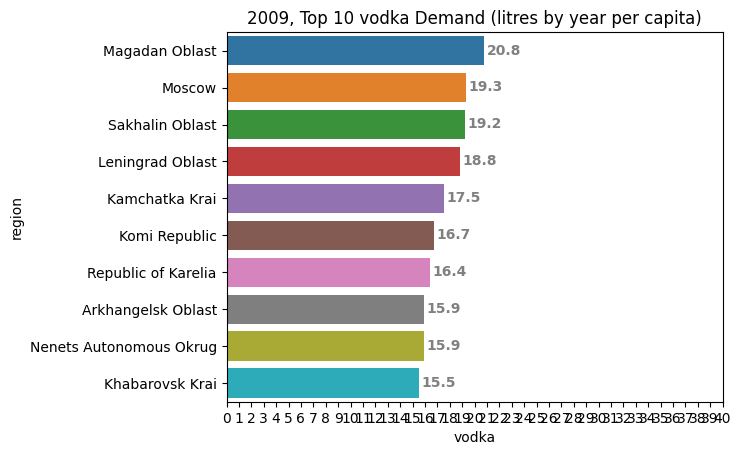

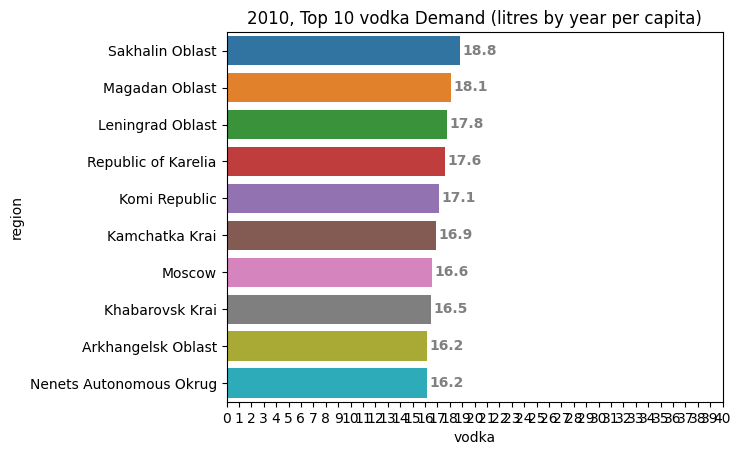

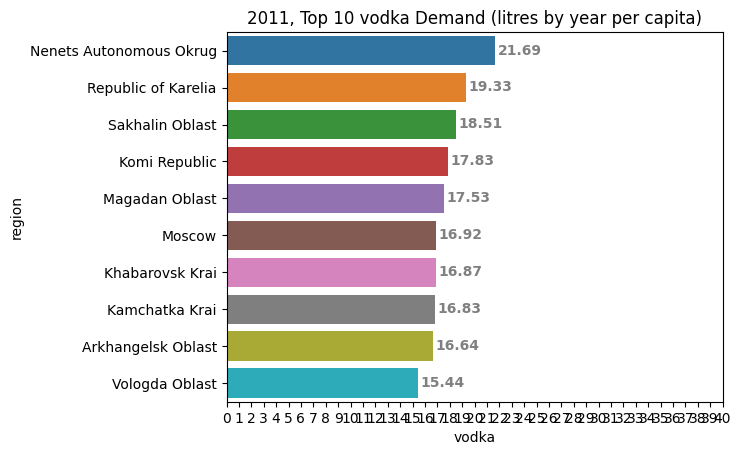

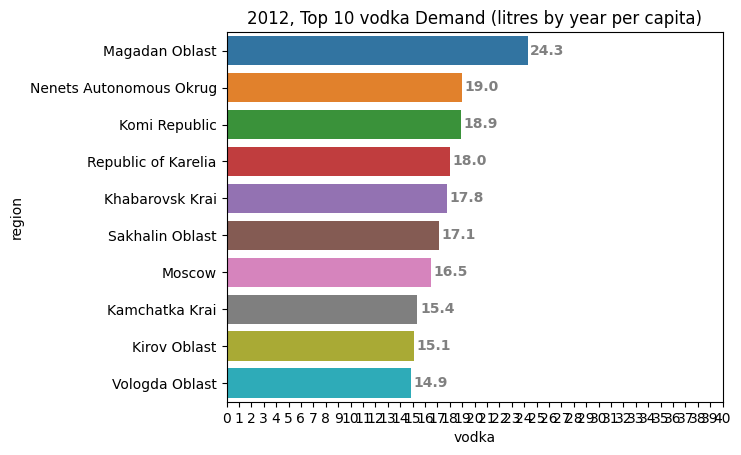

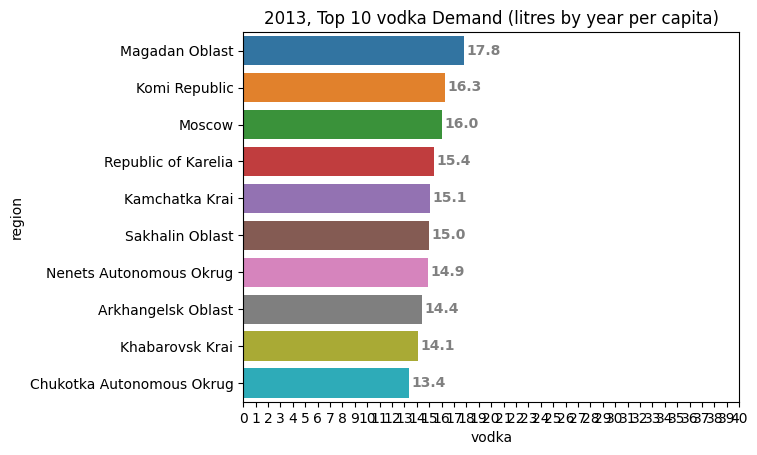

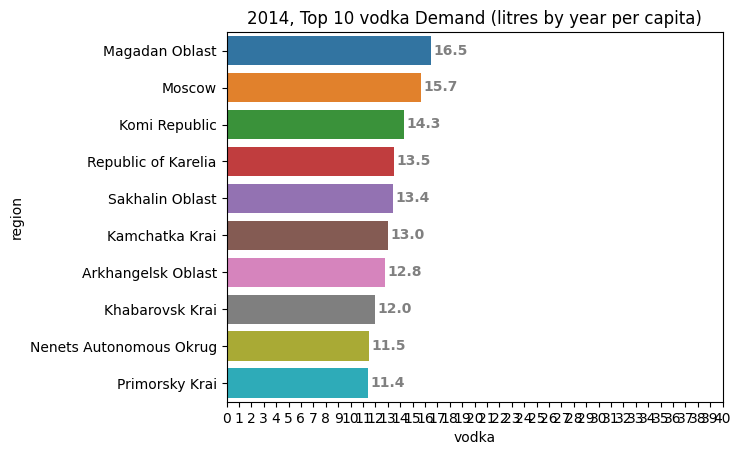

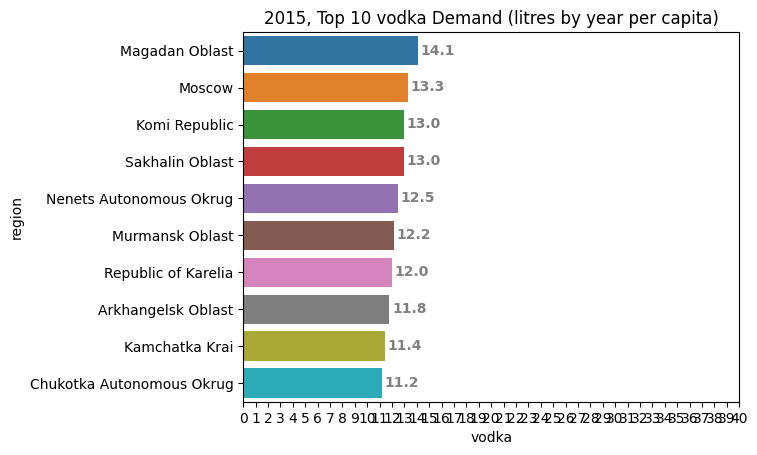

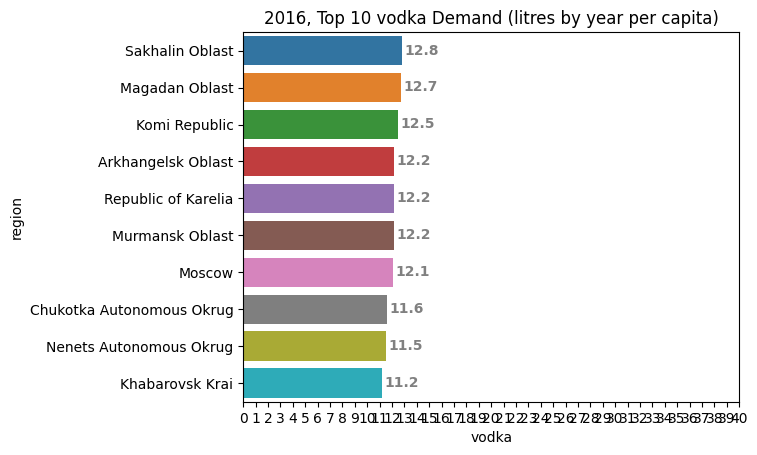

In [15]:
# Top 10 most vodka demand regions by year 
yearly_top10_plot(col='vodka')

The top rank replaced by several regions and once a place ranked the highest, the region ususally had taken the position for 2 or 3 years in a row. Those places are Kamchatka Krai, Komi Republic, Arkhangelsk Oblast, Zabaykalsky Krai and Magadan Oblast.

##### **Champagne**

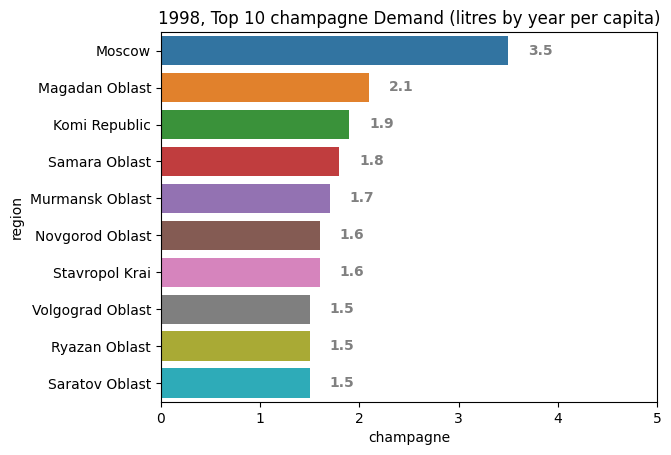

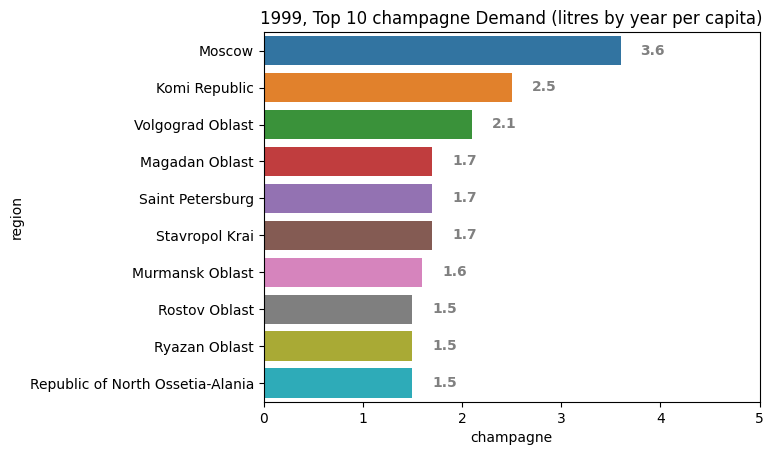

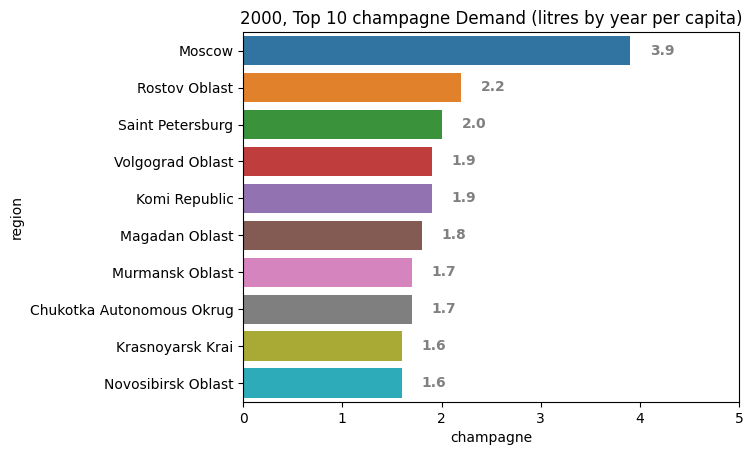

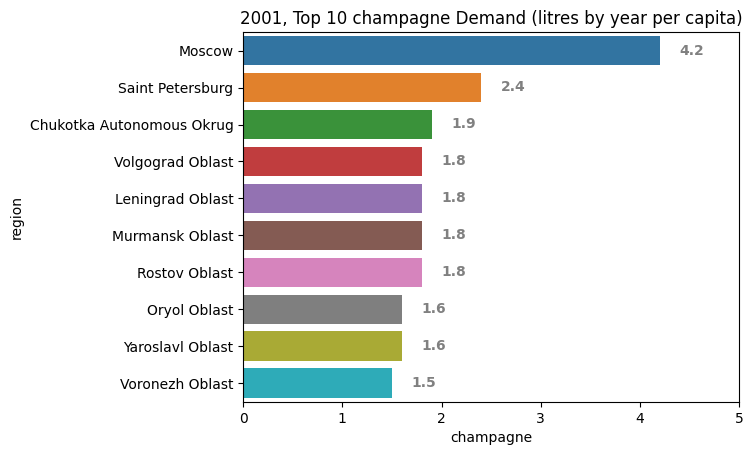

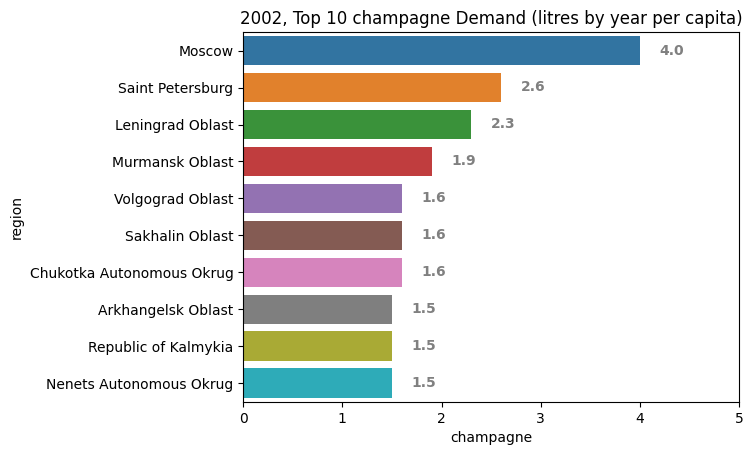

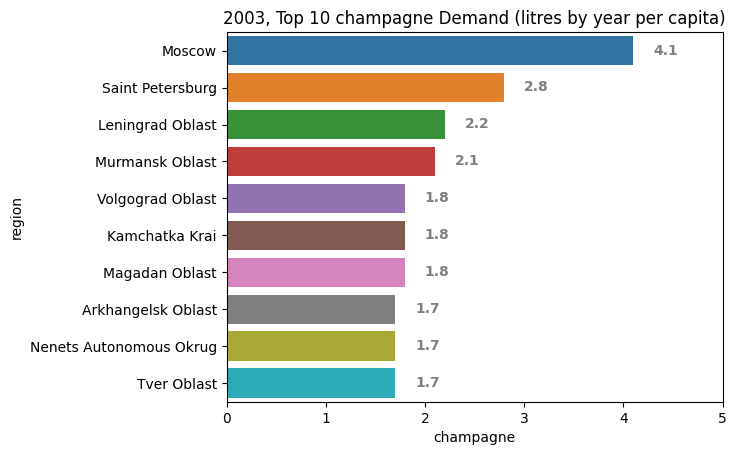

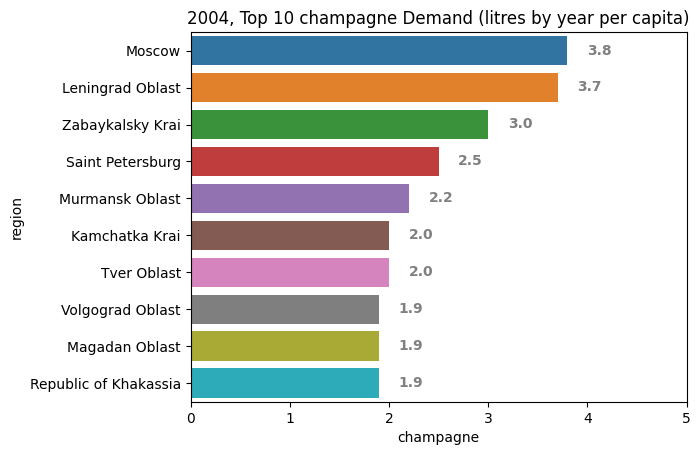

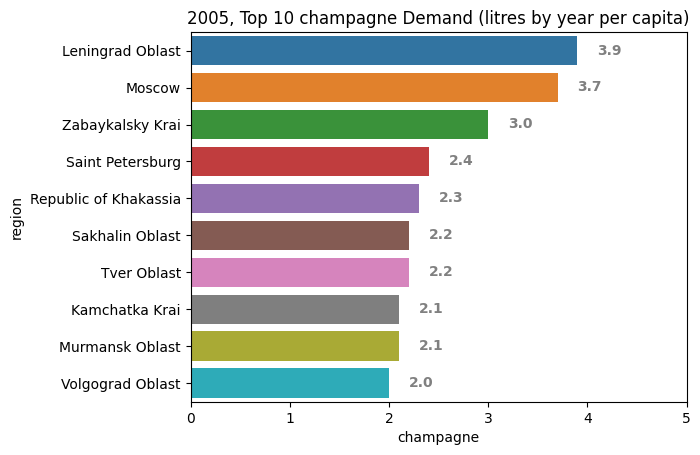

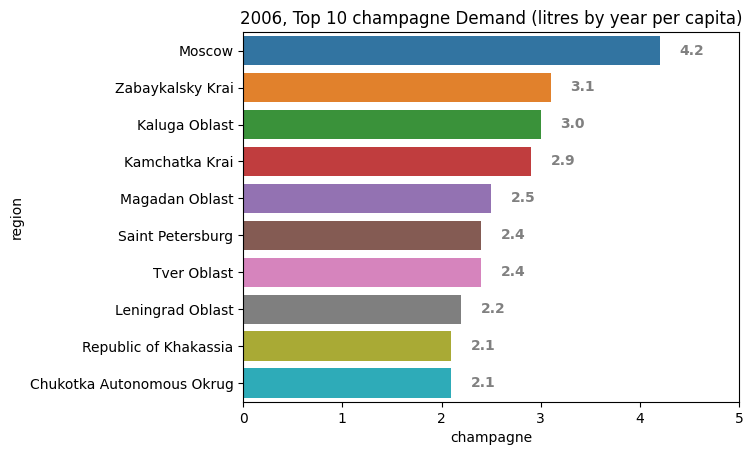

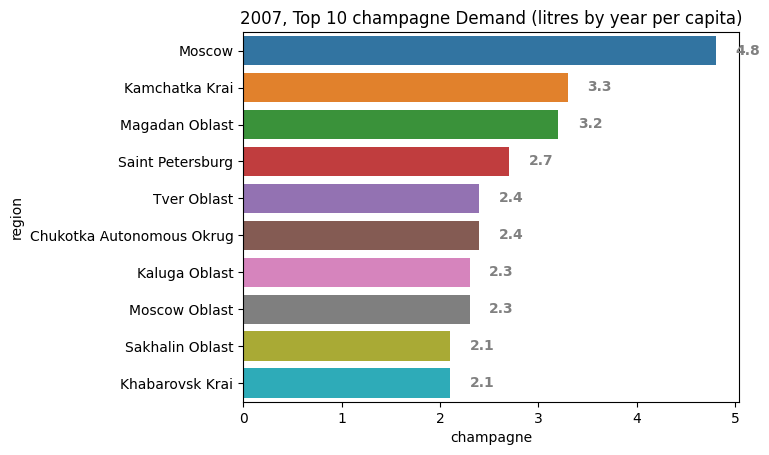

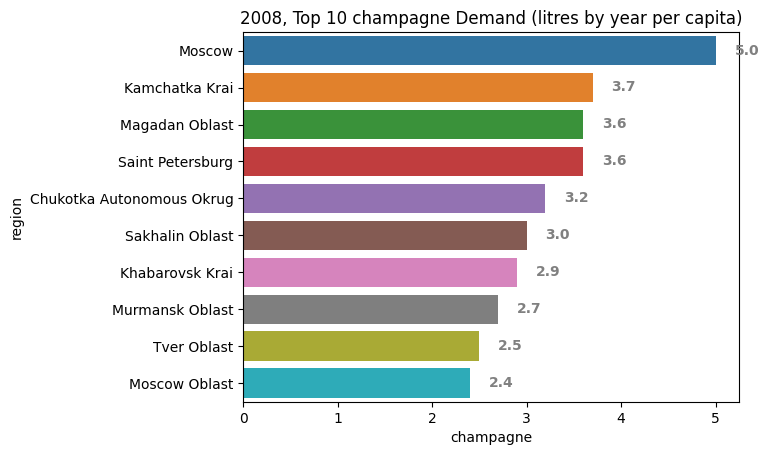

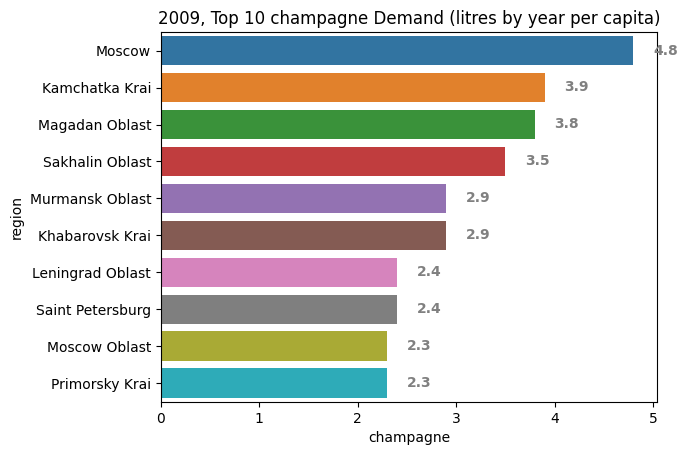

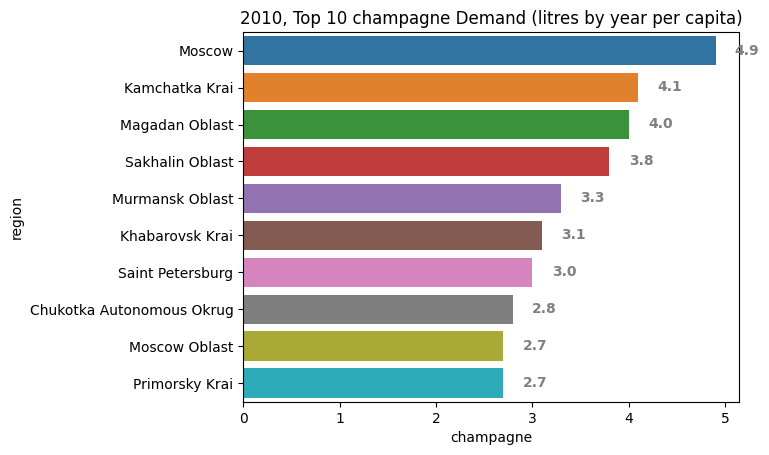

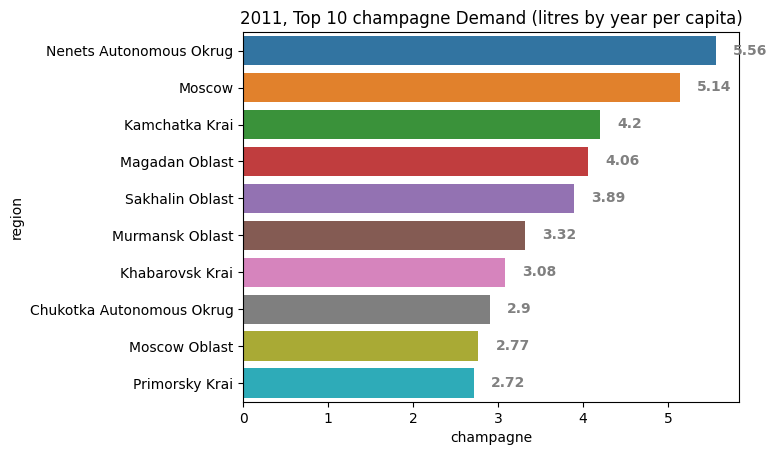

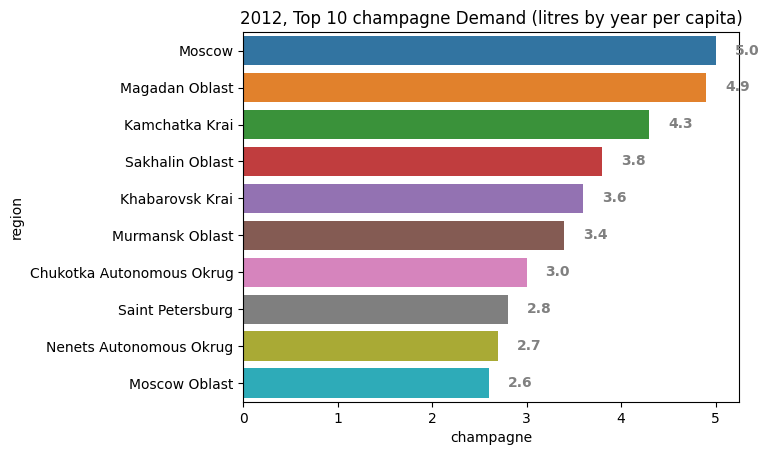

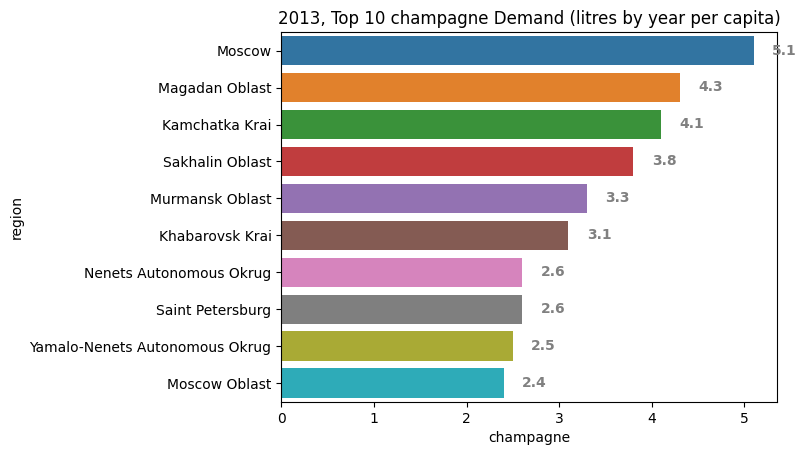

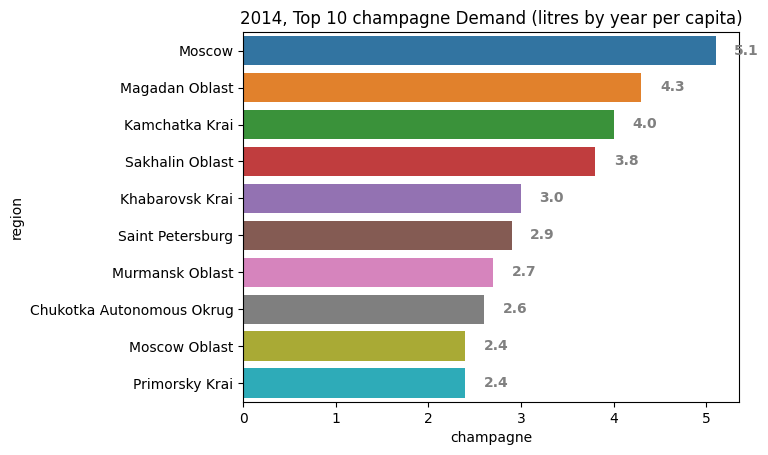

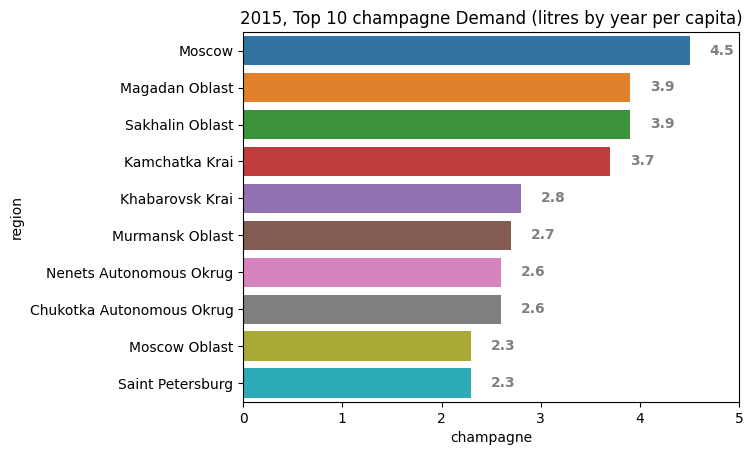

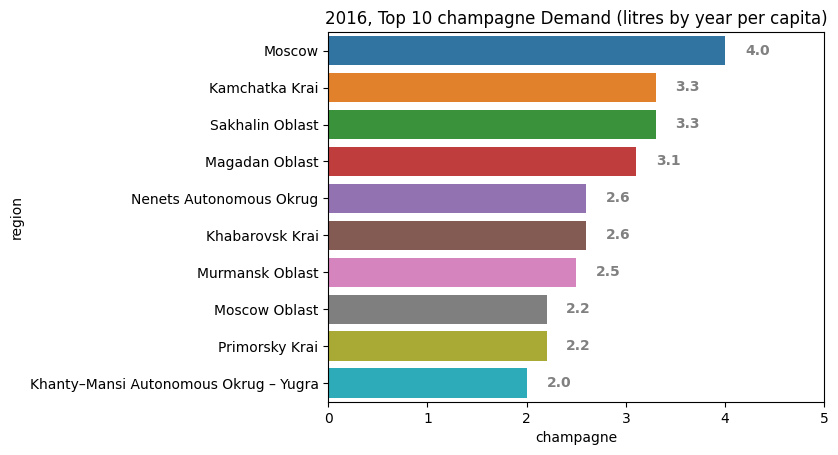

In [16]:
# Top 10 most champagne demand regions by year 
yearly_top10_plot(col='champagne') 

Unlike other drinks, champagne sales has taken by a dominent market place which is  Moscow ranked on the top all the analysis period except 2005 and 2011.

##### **Brandy**

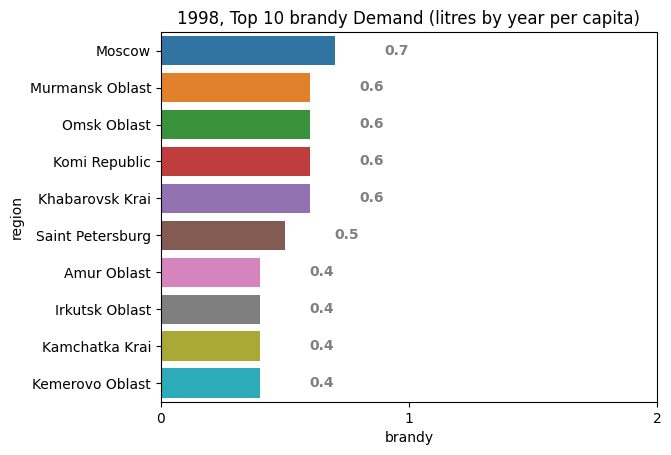

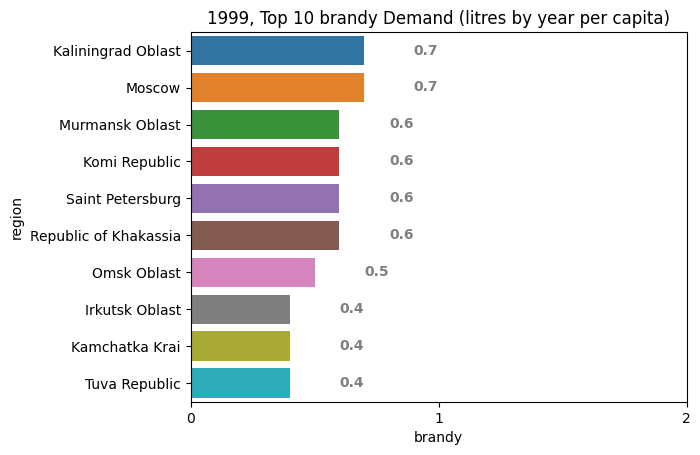

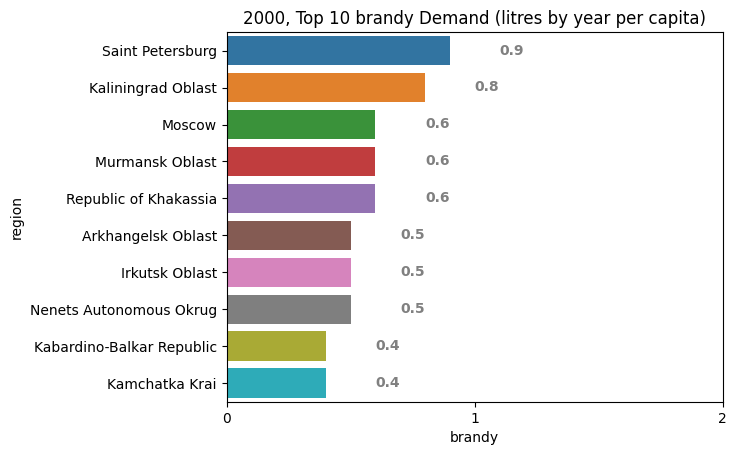

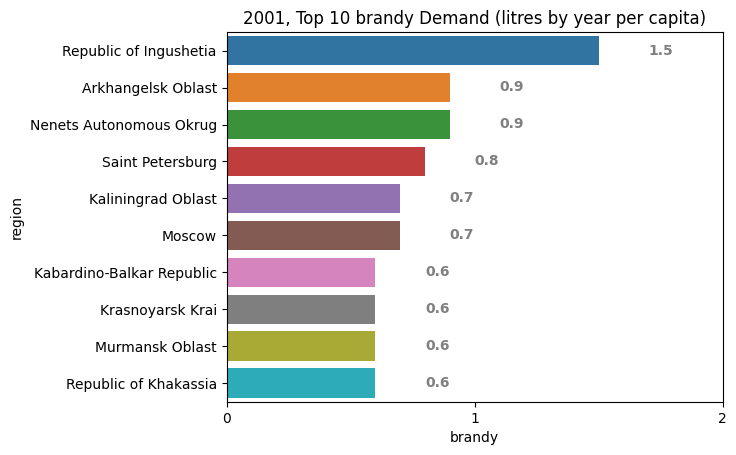

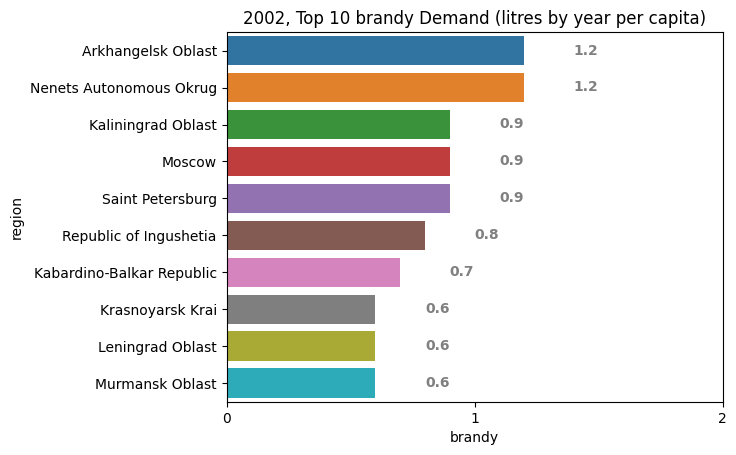

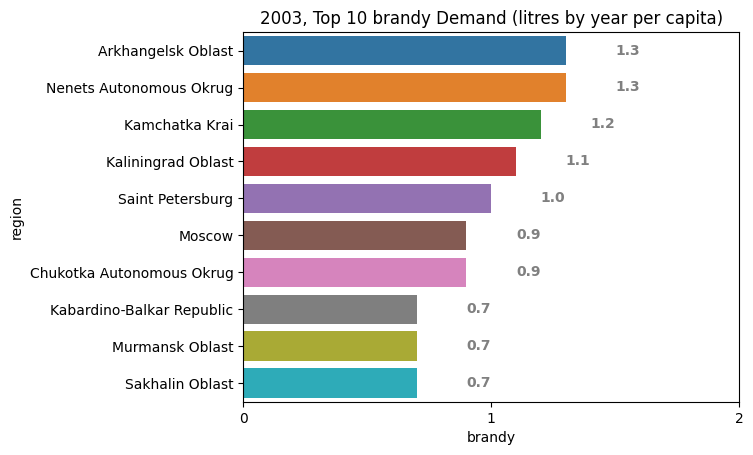

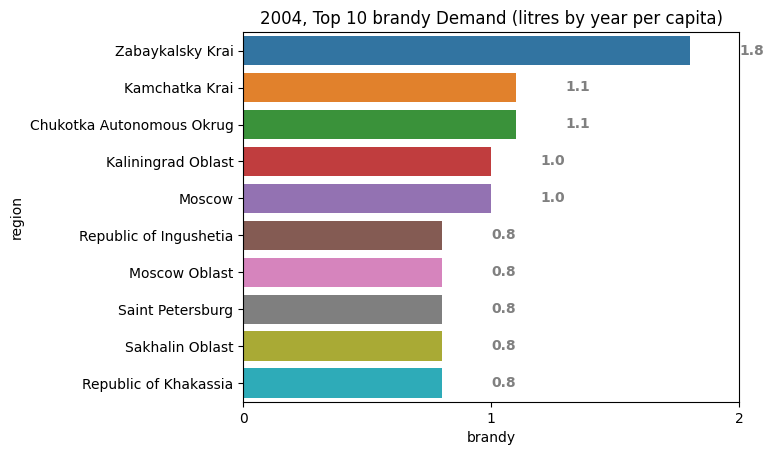

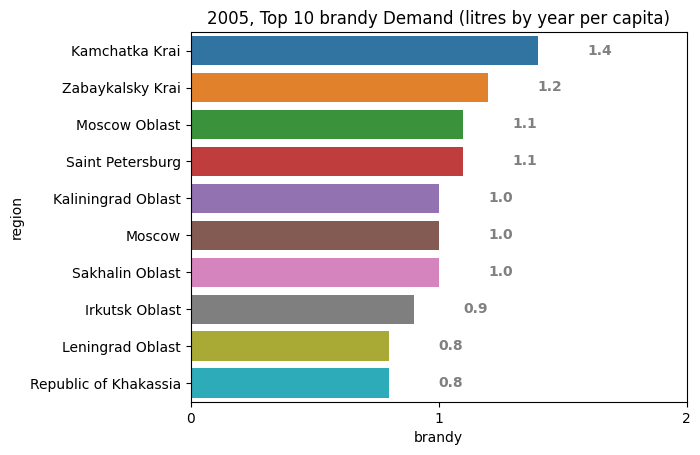

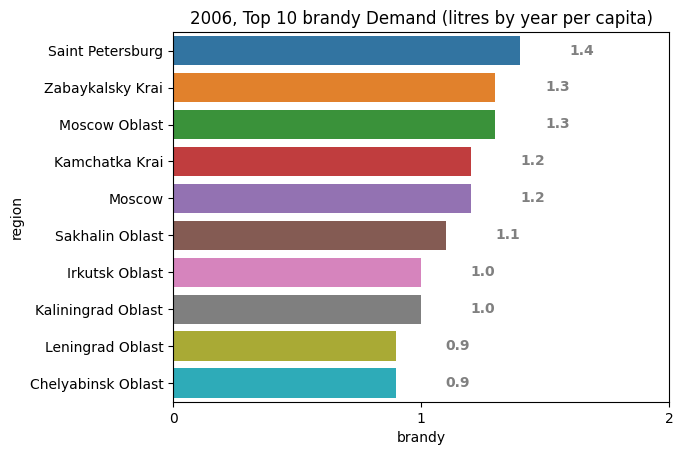

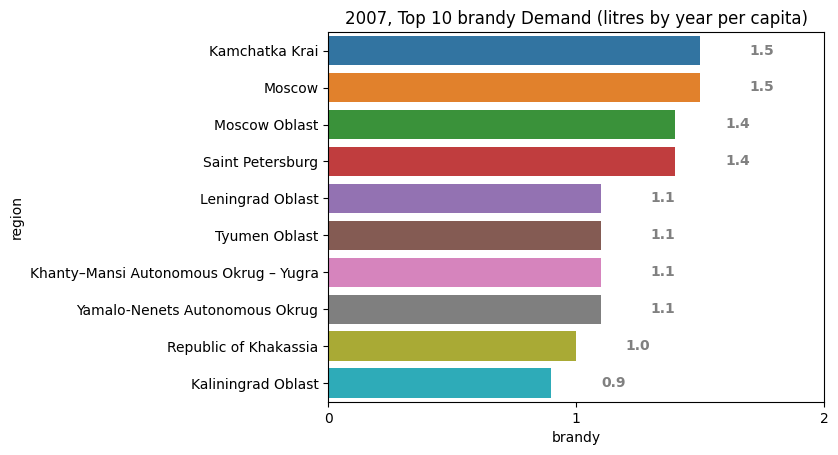

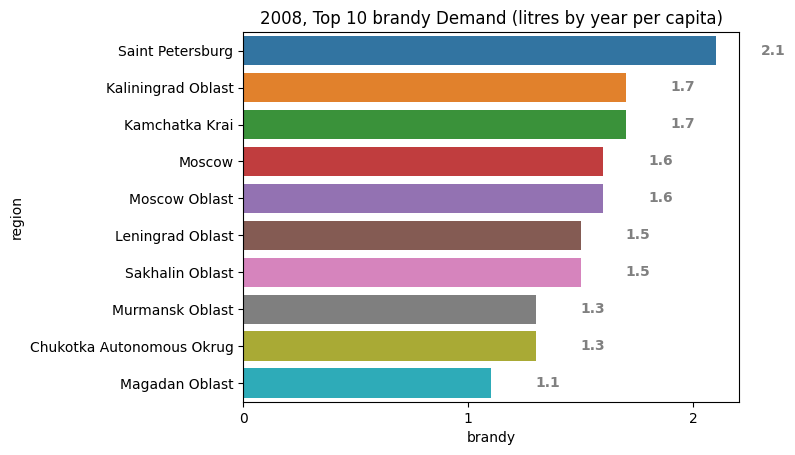

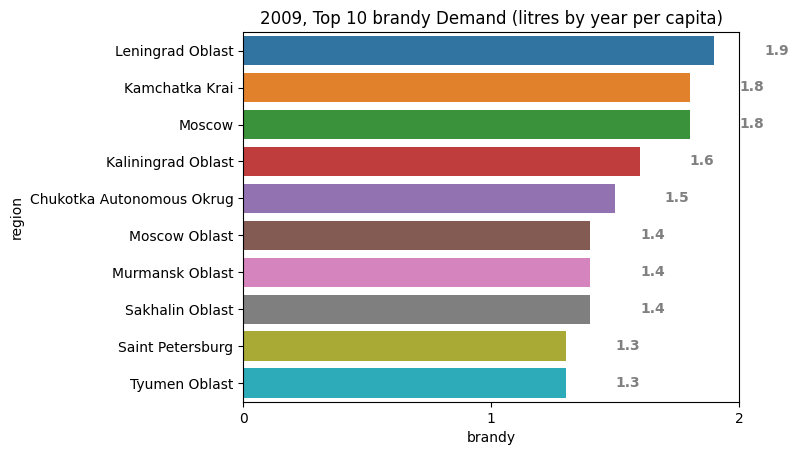

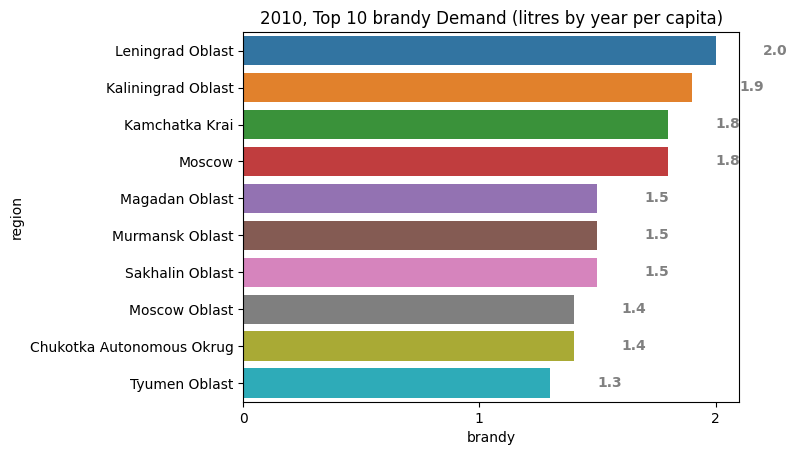

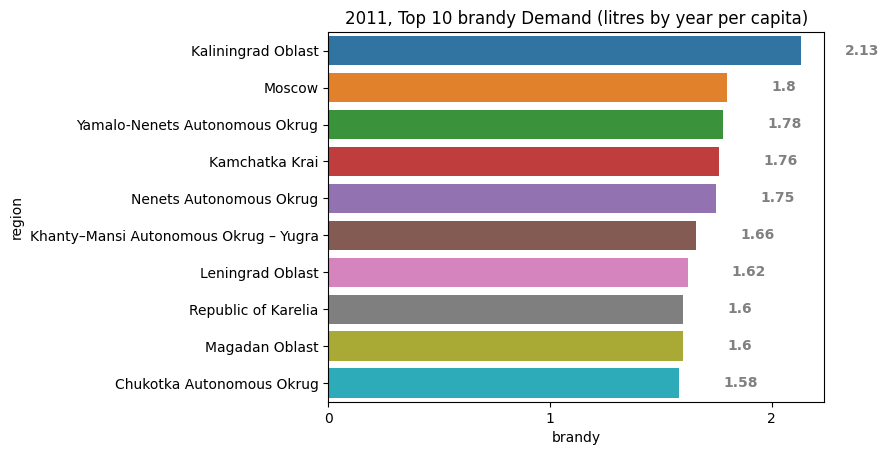

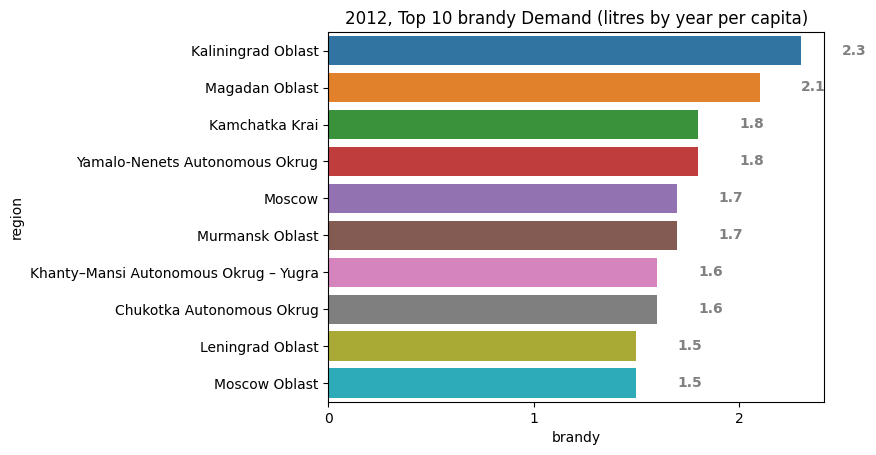

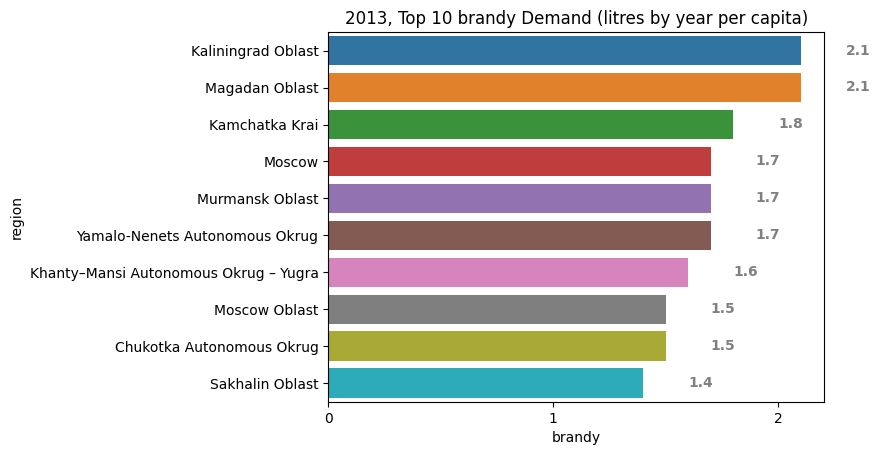

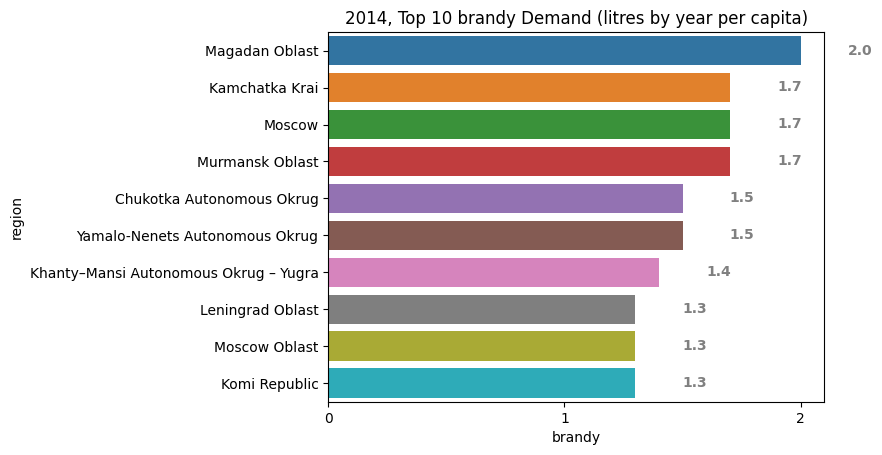

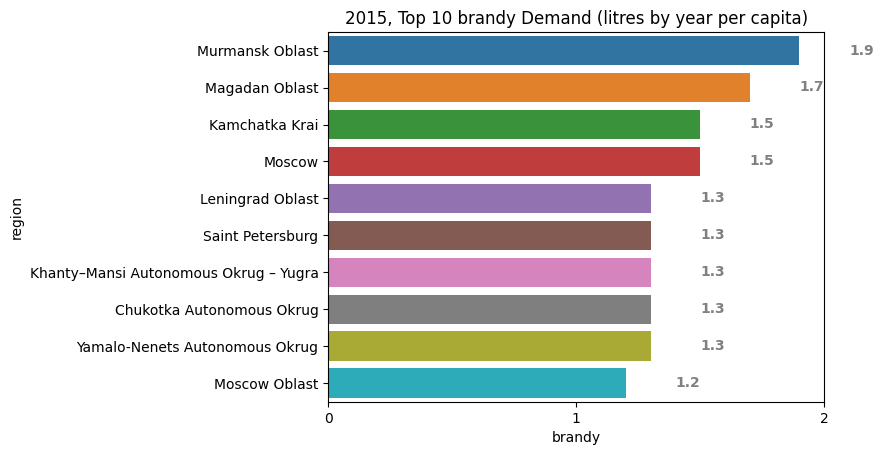

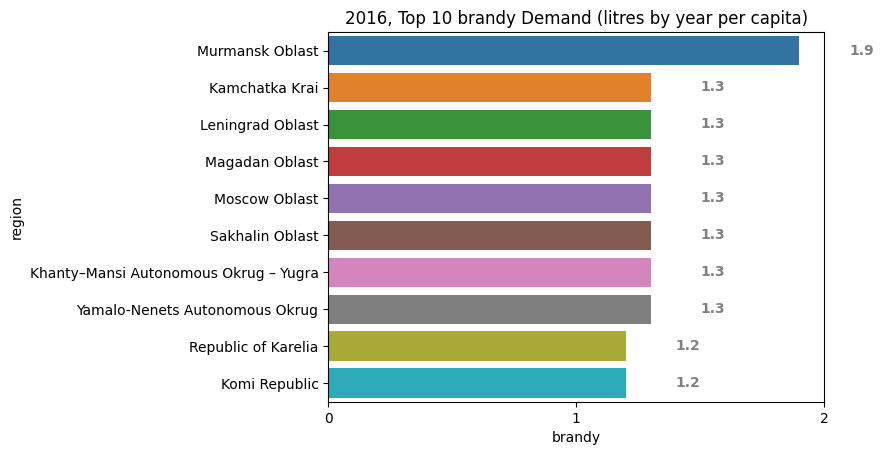

In [17]:
# Top 10 most brandy demand regions by year 
yearly_top10_plot(col='brandy')

Consumption liters per capita for brandy are quite lower than other drinks. It was less than 1 liters before 2001 even the top rank regions. After 2001, the amount of liters on top 10 ranking regions increased gradually then remained steadly.  Top ranking replaced several places like other drinks. Saint Petersburg had the top rank in 2006 and 2008.

#### Saint Petersburg Drinks consumption and ranking changes 

In [174]:
def plot_saint_change (col='wine'):
    tmp = df.loc[:,['year','region',col]]
    tmp['rank'] = tmp.groupby(['year'])[col].rank(method ='dense',ascending = False)
    sp = tmp[tmp.region == 'Saint Petersburg'].sort_values(by ='year').set_index('year')
    ax=sns.barplot(data = sp, x = sp.index , y = col, color='darkblue')
    ax.set_xticklabels(ax.get_xticklabels([]),rotation=60)
    for p in ax.patches:
        plt.text(p.get_x()+0.1, p.get_height()+0.1,
            '#'+str(int(sp.iloc[int(round(p.get_x(),0)),-1])),
            fontsize = 8, fontweight ='bold',
            color ='grey')
    plt.title("Saint Petersburg's "+ str(col).upper() + " sales ranking (#) and liters per capita changes")
    plt.ylabel('litres by year per capita')
    plt.show()

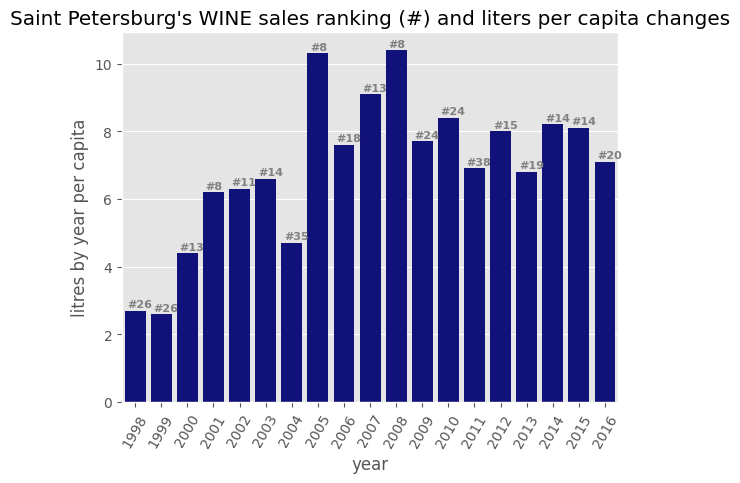

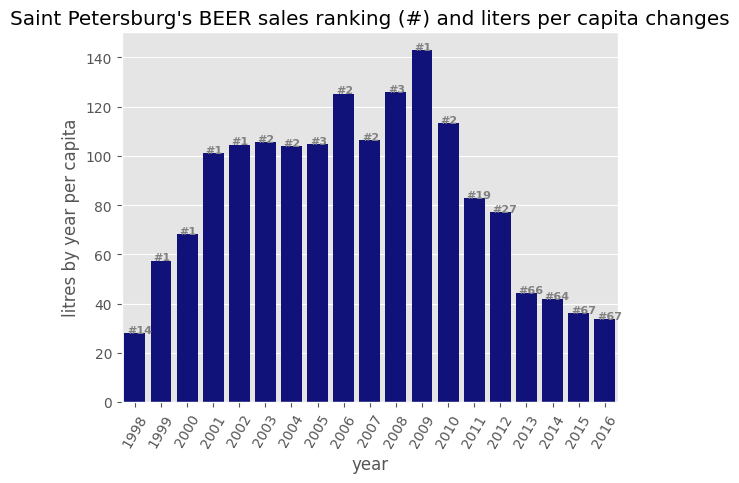

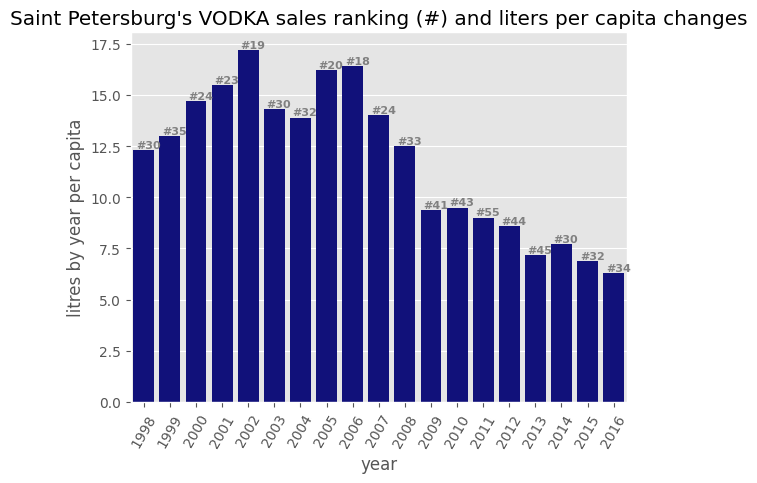

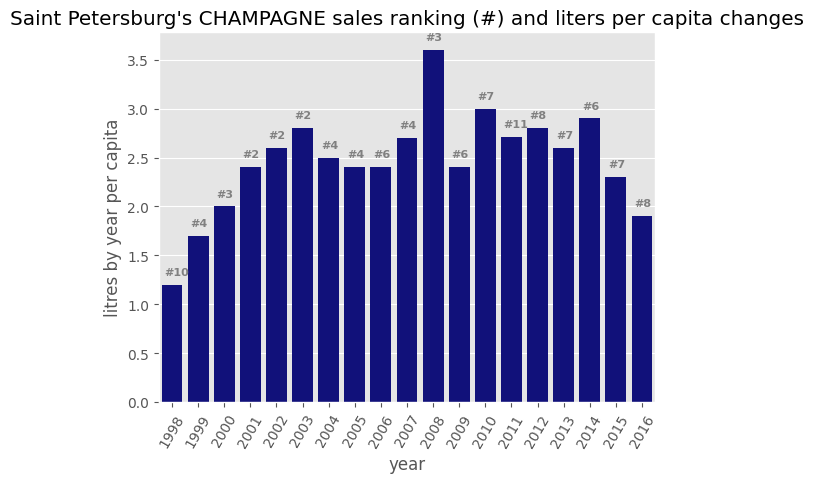

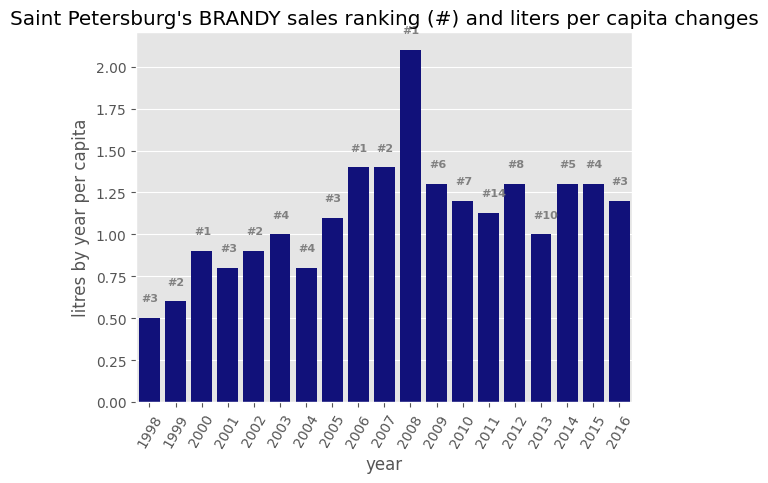

In [175]:
for drink in drinks:
    plot_saint_change(col=drink)

Saint Peterburg's *wine* consumption trend showed upward direction until it reached peak periods (2005,2008). After that, its sales and ranking reduced and remained steadily.  

*Beer* saleds were on the high rank and kept increased until 2010 then reduced dramatically.

When it comes to *vodka*, it had ranking range between 18 and 55 rank. Consumption showed decreasing direction.

Saint Petersburg had favor of *champagne* and *brandy* because ranking of sales located on top 10 on most of period 

### *Where are 10 regions having similar preference of wine like Saint Peterburg?*

### **Clustering (Unsupervised learning)**

#### Imputation

Some columns have missing values. In this analysis, missing values are filled in average number of each region. 

In [20]:
null_values =df.isnull().any(axis=1)
df[null_values]

df2=df.copy()
df2[drinks]=df2.groupby('region')[drinks].transform(lambda x: x.fillna(x.mean()))
display(df2.isnull().sum())
df2[df2.region =='Chechen Republic']

year          0
region        0
wine         19
beer          0
vodka        19
champagne    19
brandy       19
dtype: int64

year            region  wine      beer  vodka  champagne  brandy
79   1998-01-01  Chechen Republic   NaN  2.766667    NaN        NaN     NaN
164  1999-01-01  Chechen Republic   NaN  2.766667    NaN        NaN     NaN
249  2000-01-01  Chechen Republic   NaN  2.766667    NaN        NaN     NaN
334  2001-01-01  Chechen Republic   NaN  2.766667    NaN        NaN     NaN
419  2002-01-01  Chechen Republic   NaN  2.766667    NaN        NaN     NaN
504  2003-01-01  Chechen Republic   NaN  2.766667    NaN        NaN     NaN
589  2004-01-01  Chechen Republic   NaN  2.766667    NaN        NaN     NaN
674  2005-01-01  Chechen Republic   NaN  2.766667    NaN        NaN     NaN
759  2006-01-01  Chechen Republic   NaN  2.766667    NaN        NaN     NaN
844  2007-01-01  Chechen Republic   NaN  2.766667    NaN        NaN     NaN
929  2008-01-01  Chechen Republic   NaN  2.766667    NaN        NaN     NaN
1014 2009-01-01  Chechen Republic   NaN  2.766667    NaN        NaN     NaN
1099 2010-01-01  Chechen Republic   NaN  2.766667    NaN        NaN     NaN
1184 2011-01-01  Chechen Republic   NaN  2.766667    NaN        NaN     NaN
1269 2012-01-01  Chechen Republic   NaN  2.766667    NaN        NaN     NaN
1354 2013-01-01  Chechen Republic   NaN  2.766667    NaN        NaN     NaN
1439 2014-01-01  Chechen Republic   NaN  4.900000    NaN        NaN     NaN
1524 2015-01-01  Chechen Republic   NaN  2.200000    NaN        NaN     NaN
1609 2016-01-01  Chechen Republic   NaN  1.200000    NaN        NaN     NaN

In [21]:
df2.dropna(inplace=True)
display(df2.shape)

(1596, 7)

After filled in the missing values, we can see that not all the values are filled in. Chechen Republic did not have any values for all the period in wine, vodka, champagne, and brandy. That is, there is no values to fill thoese columns. Therefore, we can drop Chechen Republic from the data.

#### KMeans clustering

At firtst, Tried to use kmeans clustering in all columns. It showed clustering based on each year and region.

In [22]:
rnd=0 # random state
scaler = StandardScaler()
kmean = KMeans(n_clusters=3, random_state=rnd)

pipeline = make_pipeline(scaler, kmean)
pipeline.fit(df2[drinks])
df2['labels']=pipeline.predict(df2[drinks])
df2.tail()

year                          region  ...  brandy  labels
1610 2016-01-01                Chuvash Republic  ...     0.4       1
1611 2016-01-01       Chukotka Autonomous Okrug  ...     1.1       0
1612 2016-01-01        Sakha (Yakutia) Republic  ...     0.5       0
1613 2016-01-01  Yamalo-Nenets Autonomous Okrug  ...     1.3       0
1614 2016-01-01                Yaroslavl Oblast  ...     1.0       0

[5 rows x 8 columns]

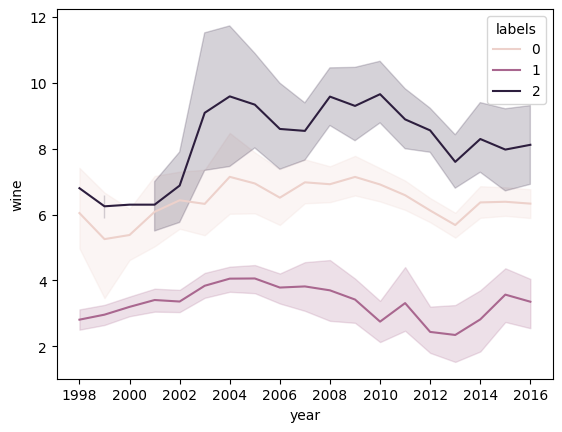

In [23]:
sns.lineplot(data=df2,x='year',y= 'wine',hue='labels')
plt.show()

In [24]:
from sklearn.metrics import silhouette_score
km_range =np.arange(3,20)
km_iner=[]
silhouette=[]
for i in km_range:
    scaler = StandardScaler()
    kmean = KMeans(n_clusters=i, random_state = rnd)
    pipeline = make_pipeline(scaler, kmean)
    pipeline.fit(df2[drinks])
    cluster_labels = kmean.labels_
    km_iner.append(kmean.inertia_)
    silhouette.append(silhouette_score(df2[drinks],cluster_labels))

<AxesSubplot: xlabel='range', ylabel='inertia'>

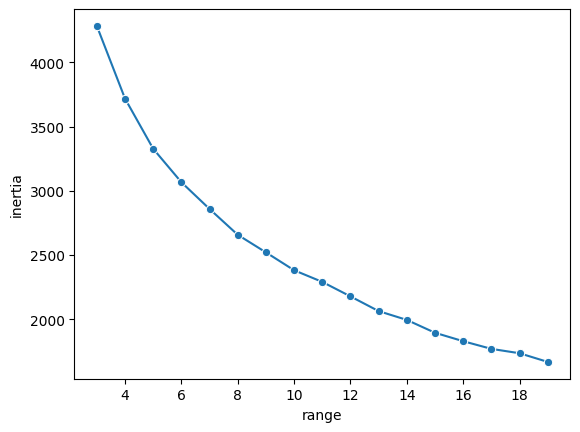

In [25]:
km_cluster=pd.DataFrame(zip(km_range,km_iner),columns=['range','inertia'])
sns.lineplot(data=km_cluster, x='range', y='inertia', marker="o")

<AxesSubplot: xlabel='range', ylabel='silhouette'>

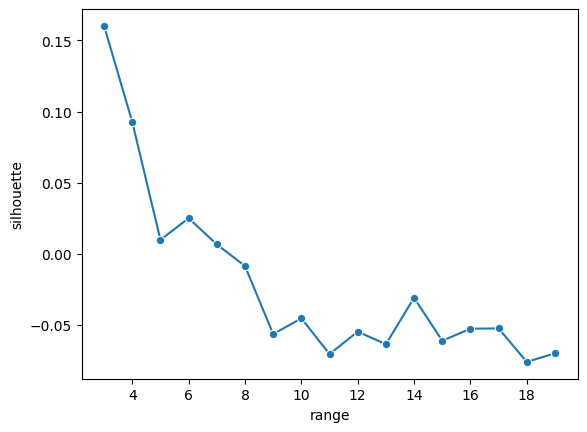

In [26]:
sil_cluster=pd.DataFrame(zip(km_range,silhouette),columns=['range','silhouette'])
sns.lineplot(data=sil_cluster, x='range', y='silhouette', marker="o")

Considering to choose n_clusters, the lower the range, the lower silhouette score (silhouette score is better close to 1)
However, In this case, what we want to know is cluster of region to give us same results as Saint Petersburg. Therefore the above way is not proper.

##### Is there any region showing similar changes as Saint Petersburg?

From the above analysis, we can check whether there is any region having similar changes over the analysis period. 

In [27]:
saint=df2[df2.region == 'Saint Petersburg']
display(saint)
year_list=saint.year.to_list()
label_list=saint.labels.to_list()
same_labels=[]
for i in range(len(year_list)):
    temp=df2.iloc[np.where((df2.year==year_list[i])&(df2.labels==label_list[i]))]
    same_labels.append(temp.region.to_list())

set.intersection(*map(set,same_labels))

year            region  wine  ...  champagne  brandy  labels
59   1998-01-01  Saint Petersburg   2.7  ...       1.20    0.50       1
144  1999-01-01  Saint Petersburg   2.6  ...       1.70    0.60       0
229  2000-01-01  Saint Petersburg   4.4  ...       2.00    0.90       0
314  2001-01-01  Saint Petersburg   6.2  ...       2.40    0.80       2
399  2002-01-01  Saint Petersburg   6.3  ...       2.60    0.90       2
484  2003-01-01  Saint Petersburg   6.6  ...       2.80    1.00       2
569  2004-01-01  Saint Petersburg   4.7  ...       2.50    0.80       2
654  2005-01-01  Saint Petersburg  10.3  ...       2.40    1.10       2
739  2006-01-01  Saint Petersburg   7.6  ...       2.40    1.40       2
824  2007-01-01  Saint Petersburg   9.1  ...       2.70    1.40       2
909  2008-01-01  Saint Petersburg  10.4  ...       3.60    2.10       2
994  2009-01-01  Saint Petersburg   7.7  ...       2.40    1.30       2
1079 2010-01-01  Saint Petersburg   8.4  ...       3.00    1.20       2
1164 2011-01-01  Saint Petersburg   6.9  ...       2.71    1.13       2
1249 2012-01-01  Saint Petersburg   8.0  ...       2.80    1.30       2
1334 2013-01-01  Saint Petersburg   6.8  ...       2.60    1.00       0
1419 2014-01-01  Saint Petersburg   8.2  ...       2.90    1.30       2
1504 2015-01-01  Saint Petersburg   8.1  ...       2.30    1.30       2
1589 2016-01-01  Saint Petersburg   7.1  ...       1.90    1.20       0

[19 rows x 8 columns]

{'Saint Petersburg'}

As we seen from the result above, there is no other place having similar changes from 1998 to 2016.

In [28]:
# from tslearn.clustering import TimeSeriesKMeans

##### Wine demand changes only

In [29]:
wine=df2.loc[:,['year','region','wine']]
wine=pd.pivot_table(data=wine,index='region',values='wine',columns='year')
wine

year                            1998-01-01  1999-01-01  ...  2015-01-01  2016-01-01
region                                                  ...                        
Altai Krai                             3.3         2.2  ...         4.4         4.8
Altai Republic                         3.4         4.8  ...         4.3         4.5
Amur Oblast                            2.1         2.9  ...         6.0         6.2
Arkhangelsk Oblast                     4.3         4.6  ...         9.0         8.4
Astrakhan Oblast                       2.9         3.8  ...         4.7         4.5
...                                    ...         ...  ...         ...         ...
Vologda Oblast                         3.9         2.5  ...         8.5         8.6
Voronezh Oblast                        1.3         2.1  ...         5.5         5.5
Yamalo-Nenets Autonomous Okrug         3.0         4.1  ...         4.6         4.5
Yaroslavl Oblast                       3.5         3.6  ...         9.3        10.2
Zabaykalsky Krai                       0.9         1.1  ...         6.6         6.4

[84 rows x 19 columns]

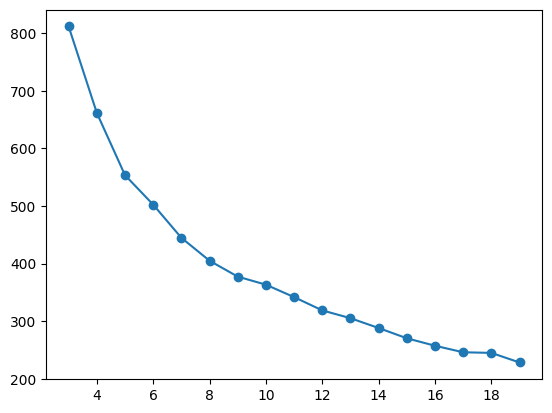

In [30]:
km_range =np.arange(3,20)
wine_distortion=[]
silhouette=[]
for i in km_range:
    scaler = StandardScaler()
    kmean = KMeans(n_clusters=i, random_state = rnd)
    pipeline = make_pipeline(scaler, kmean)
    pipeline.fit(wine)
    wine_distortion.append(kmean.inertia_)
#     silhouette.append(silhouette_score(df2[drinks],cluster_labels))
plt.plot(range(3,20),wine_distortion,marker='o')

In [31]:
kmean = KMeans(n_clusters=5, random_state = rnd)
pipeline = make_pipeline(scaler, kmean)
pipeline.fit(wine)
wine['clusters']=pipeline.predict(wine)
wine

year                            1998-01-01 00:00:00  ...  clusters
region                                               ...          
Altai Krai                                      3.3  ...         0
Altai Republic                                  3.4  ...         3
Amur Oblast                                     2.1  ...         2
Arkhangelsk Oblast                              4.3  ...         4
Astrakhan Oblast                                2.9  ...         2
...                                             ...  ...       ...
Vologda Oblast                                  3.9  ...         4
Voronezh Oblast                                 1.3  ...         2
Yamalo-Nenets Autonomous Okrug                  3.0  ...         3
Yaroslavl Oblast                                3.5  ...         1
Zabaykalsky Krai                                0.9  ...         1

[84 rows x 20 columns]

In [32]:
wine[wine.index == 'Saint Petersburg']

year              1998-01-01 00:00:00  ...  clusters
region                                 ...          
Saint Petersburg                  2.7  ...         1

[1 rows x 20 columns]

In [33]:
wine.clusters.value_counts()

2    26
3    20
1    18
0    13
4     7
Name: clusters, dtype: int64

In [34]:
km_result=wine[wine.clusters == 1].index.to_list()
print(len(km_result))
km_result

18


['Bryansk Oblast',
 'Chelyabinsk Oblast',
 'Ivanovo Oblast',
 'Kaliningrad Oblast',
 'Kirov Oblast',
 'Leningrad Oblast',
 'Mari El Republic',
 'Moscow Oblast',
 'Murmansk Oblast',
 'Penza Oblast',
 'Republic of Khakassia',
 'Saint Petersburg',
 'Sakhalin Oblast',
 'Smolensk Oblast',
 'Sverdlovsk Oblast',
 'Tver Oblast',
 'Yaroslavl Oblast',
 'Zabaykalsky Krai']

Here, we choose only wine consumption changes. Saint Petersburg is clustered group 1 and 17 regions are in same cluster. Our promotion target regions are only 10 regions, but we have 17 regions from our analysis. 

####  Hierarchy clustering

Hierarchy is one of methods what we can use to find clustering groups. 

In [35]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

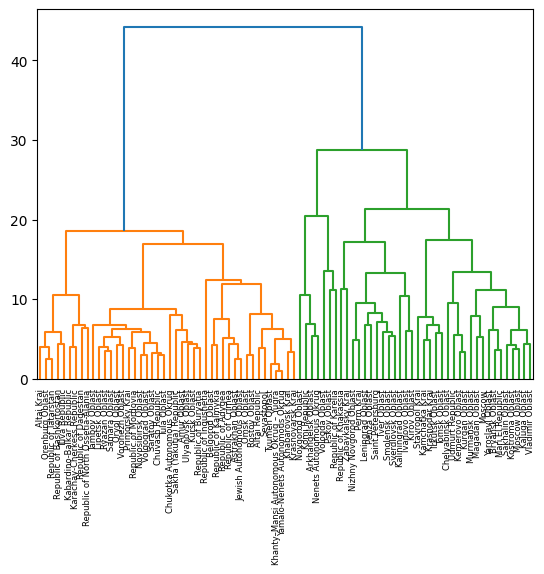

In [36]:
wine2=df2.loc[:,['year','region','wine']]
wine2=pd.pivot_table(data=wine2,index='region',values='wine',columns='year')
wine2
mergings=linkage(wine2, method='complete')
dendrogram(mergings,labels=wine.index)
plt.show()

In [37]:
wine2['labels']=fcluster(mergings,20,criterion='distance')# Cut the heights of cluster as 20 
wine2.labels.value_counts() 

1    44
5    20
4    13
2     4
3     3
Name: labels, dtype: int64

In [38]:
wine2[wine2.index == 'Saint Petersburg'] # saint petersburs is in label 4

year              1998-01-01 00:00:00  ...  labels
region                                 ...        
Saint Petersburg                  2.7  ...       4

[1 rows x 20 columns]

In [39]:
hei_result=wine2[wine2.labels == 4].index.to_list()
print(len(hei_result))
hei_result 

13


['Ivanovo Oblast',
 'Kaliningrad Oblast',
 'Kirov Oblast',
 'Leningrad Oblast',
 'Nizhny Novgorod Oblast',
 'Penza Oblast',
 'Perm Krai',
 'Republic of Khakassia',
 'Saint Petersburg',
 'Smolensk Oblast',
 'Sverdlovsk Oblast',
 'Tver Oblast',
 'Zabaykalsky Krai']

Hierarchical clustering have 5 clusters. Saint Petersburg is in label 4 and 13 regions are in the same group.

In [40]:
fin_result=list(set(hei_result) & set(km_result))
fin_result.remove('Saint Petersburg')
fin_result

['Kaliningrad Oblast',
 'Penza Oblast',
 'Zabaykalsky Krai',
 'Smolensk Oblast',
 'Republic of Khakassia',
 'Sverdlovsk Oblast',
 'Leningrad Oblast',
 'Kirov Oblast',
 'Ivanovo Oblast',
 'Tver Oblast']

10 regions are included in  both of results. Each mothod has criteria for clustering standards. 10 regions are considered to belong the same cluster in different methods. Therefore, it might much suitable to consider those 10 regions than other regions. 

### Limitation and further consideration

From our analysis, we cannot explain reasons of consumption changes. For doing that, we need geographical or demographical analysis.
Here, we clusteres regions based on Kmeans and hierarchy clustering methods and only considered wine consumption amounts. Drinks, wine, beer, vodka, champagne, and brandy, are not complementary goods ranther than substitutional goods.  For the further consideration, we can include other drinks in the models and using feature engineering. Not only that, we can use other models and methods. 